# The Timeseries Quantum Autoencoder (TS unary encoding)
*TS QAE in Qiskit with unary encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023<br>
Aims: The goal of this tutorial is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Individual TS values were encoded in their binary representation.
- Amplitude encoding of TS windows was used, but was padded with zeros (0) to ensure the total number of values to be $2^n$.
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
5. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes

## The Quantum Autoencoder 

The Quantum Autoencoder, similarly to the Classical Autoencoder (CAE), reduces the dimensionality of the model input. Its circuit includes an input state which is prepared by the Encoder (this requires measuring and reinitialising the bottom "trash" qubits), the bottleneck state which compresses input data, and an output state which is prepared by the Decoder (see Figure).

<div>
    <!--img src="attachment:qae_fig2_wide.png" width="1000"-->
    <img src="../images/qae.png" width="1000">
</div>

**Figure: Pictorial Representation of a Quantum Autoencoder**
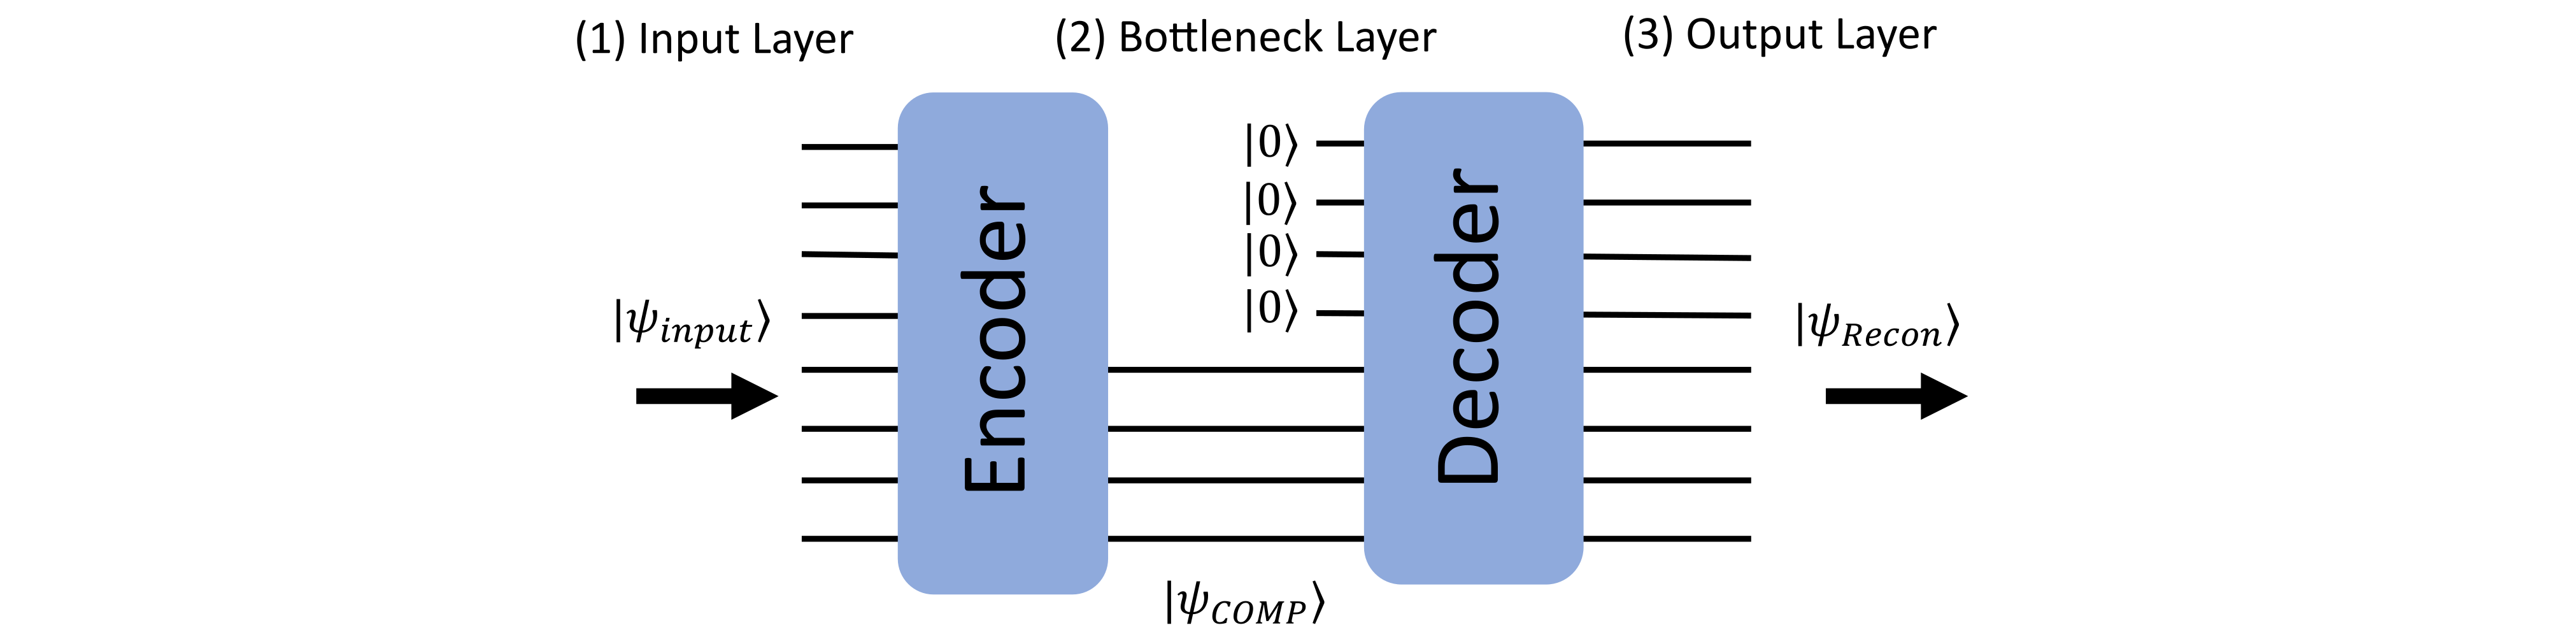

 

Much like its classical counterpart, our circuit contains three layers. We first input our state $|\psi>$ (which contains $n$ qubits), of which we wish to compress. This is our input layer (1). 

We then apply our parametrized circuit on our input state, which will act as our encoder and 'compresses' our quantum state, reducing the dimensionality of our state to $n-k$ qubits. Our new compressed state is of the form $|\psi_{comp}> \otimes |0>^{\otimes k}$, where $|\psi_{comp}>$ contains $n-k$ qubits. 

This parametrized circuit will depend on a set of parameters, which will be the nodes of our Quantum Autoencoder. Throughout the training process, these parameters will be updated to optimize the loss function. 

We disregard the remaining $k$ qubits for the remainder of the circuit. This is our bottleneck layer (2) and our input state is now compressed. 

The final layer consists of the addition of $k$ qubits (all in the state $|0\rangle$) and applying another parametrized circuit between the compressed state and the new qubits. This parametrized circuit acts as our decoder and reconstructs the input state from the compressed state using the new qubits. After the decoder, we retain the original state as the state travels to the output layer (3).

## Components of a Quantum Autoencoder

Before building our Quantum Autoencoder, we must note a few subtleties:
- We first note that we cannot introduce or disregard qubits in the middle of a Quantum Circuit when implementing an autoencoder using Qiskit.
- Because of this we must include our reference state as well as our auxiliary qubits (whose role will be described in later sections) at the beginning of the circuit.
- Therefore our QAE structure will consist of our input state, reference state and one auxiliary qubit, as well as a classical register to perform measurements.

## Choosing a Loss Function 

We now define our cost function, which we will use to train our Quantum Autoencoder, to return the input state. There's a bit of math involved here, so skip this section if you're not interested! 

We take the cost function as defined in [2], which tries to maximize the fidelity between the input and output state of our Quantum Autoencoder. 

We first define subsystems $A$ and $B$ to contain $n$ and $k$ qubits respectively, while $B'$ is the space which will contain our reference space. We call the subsystem $A$ our latent space, which will contain the compressed qubit state, and $B$ our trash space, which contain the qubits of which we disregard throughout compression. 

Our input state therefore $|\psi_{AB}>$ contains $n + k$ qubits. We define the reference space $B'$ which contains the reference state $|a>_{B'}$. This space will contain the additional $k$ qubits we use in the decoder. All of these subsystems can be seen in Figure 3. 

We define the parameterized circuit as $U(\theta)$ which we will use as our encoder. However the structure and parameters of our parametrized circuit is currently unknown to us and may vary for different input states. To determine the parameters to compress our input state, we must train our device to maximally compress the state by adjusting the values of the parameters $\theta$. For the decoder we will use $U^{\dagger}(\theta)$.

Our goal therefore is to maximize the fidelity between the input and output states, i.e.

$$\text{max }F(\psi_{AB}, \rho_{out})$$

where

$$\rho_{out} = U^{\dagger}(\theta)_{AB'} \text{Tr}_{B} [U(\theta)_{AB}[\psi_{AB} \otimes a_{B'}]U^{\dagger}(\theta)_{AB}]U(\theta)_{AB'}$$

We can maximize this fidelity by tuning the parameters $\theta$ in our parametrized circuit. However, this fidelity can at times be complicated to determine and may require a large amount of gates needed to calculate the fidelity between two states, i.e. the larger the number of qubits, the more gates required which results to deeper circuits.  Therefore we look for alternative means of comparing the input and output states. 

As shown in [2] a simpler way of determining an optimally compressed state is to perform a swap gate between the trash state and reference state. These states usually have a smaller number of qubits and are therefore easier to compare, due to the smaller amount of gates required. As shown in [2] maximizing the fidelity of such these two states is equivalent to maximizing the fidelity of the input and output state and thus determining an optimal compression of our input circuit. 

Keeping our reference state fixed, our cost function will now be a function of the trash state and is denoted as; 

$$\text{max }F(\text{Tr}_{A} [ U(\theta)_{AB}\psi_{AB} U^{\dagger}(\theta)_{AB}], a_{B'})$$

Throughout the training process, we adjust the parameters $\theta$ in our encoder and perform a swap test (as described below) to determine the fidelity between these trash and reference states. In doing so, we must include an additional qubit, our auxiliary qubit, which will be used throughout the swap test and measured to determine the overall fidelity of the trash and reference states. This is the reason why we included both an auxiliary qubit and classical register in the previous section when initializing our circuit.  

### The SWAP Test

The SWAP Test is a procedure commonly used to compare two states by applying CNOT gates to each qubit (for further information see [3]). By running the circuit $M$ times, and applying the SWAP test, we then measure the auxiliary qubit. We use the number of states in the state $|1\rangle$ to compute:

$$S = 1 - \frac{2}{M}L$$

where $L$ is the count for the states in the $|1\rangle$ state. As shown in [3], maximizing this function corresponds to the two states of which we are comparing being identical. We therefore aim to maximize this function, i.e. minimize  $\frac{2}{M}L$. This value will be therefore be our cost function.

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip list | grep -E 'qiskit|torch'

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0


In [3]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/qiskit_qae',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages',
 '.',
 '..']

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *

## Prepare windowed TS data
*Values need to be in [-100..+100] range*

### Prepare a time series

In [5]:
### Start random process
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 2022

### Data settings
samples = 8*20
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 8
wind_step = 2
horizon = 1
scale = 1 # 2
pan = 0 # -1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
#y_all = f.fun(X_all)
# y_all = [round(x*scaler, 0) for x in f.fun(X_all)]
y_all = [(x*scale+pan) for x in f.fun(X_all)]
X_all = [x for x in range(len(X_all))]

### Split data into windows
# Create windowed time series, ignore X units
# However, as the task is not predictive, so the horizon is ignored
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = ts_wind_split(
    ts_wind_make(X_all, wind_size, wind_step), 
    ts_wind_make(y_all, wind_size, wind_step), 
    train_pc)

### Show TS parameters
print(f'Selected Data\n')
print(f'Function: {f.name}, Eps: {f.eps()}')
print(f'Samples: {samples}, Split: {train_pc}, Train Samples: {samples_train}, Valid Samples: {samples_valid}')
print(f'Window Size: {wind_size}, Step: {wind_step}, Horizon: {horizon}')
print(f'Range: {(round(lb, 3), round(ub, 3))}')
print(f'Training Range: {(round(lb_train, 3), round(ub_train, 3))}')
print(f'Validation Range: {(round(lb_valid, 3), round(ub_valid, 3))}')
print(f'T: {(round(ub-lb, 3))}')
print()
print(f'Training Windows: {X_train_ts.shape[0]}, Validation Windows: {X_valid_ts.shape[0]}')

Selected Data

Function: Target_2_sins, Eps: 0.1
Samples: 160, Split: 0.7, Train Samples: 112, Valid Samples: 48
Window Size: 8, Step: 2, Horizon: 1
Range: (-6.283, 6.283)
Training Range: (-6.283, 2.513)
Validation Range: (2.513, 6.283)
T: 12.566

Training Windows: 110, Validation Windows: 47


### Plot data

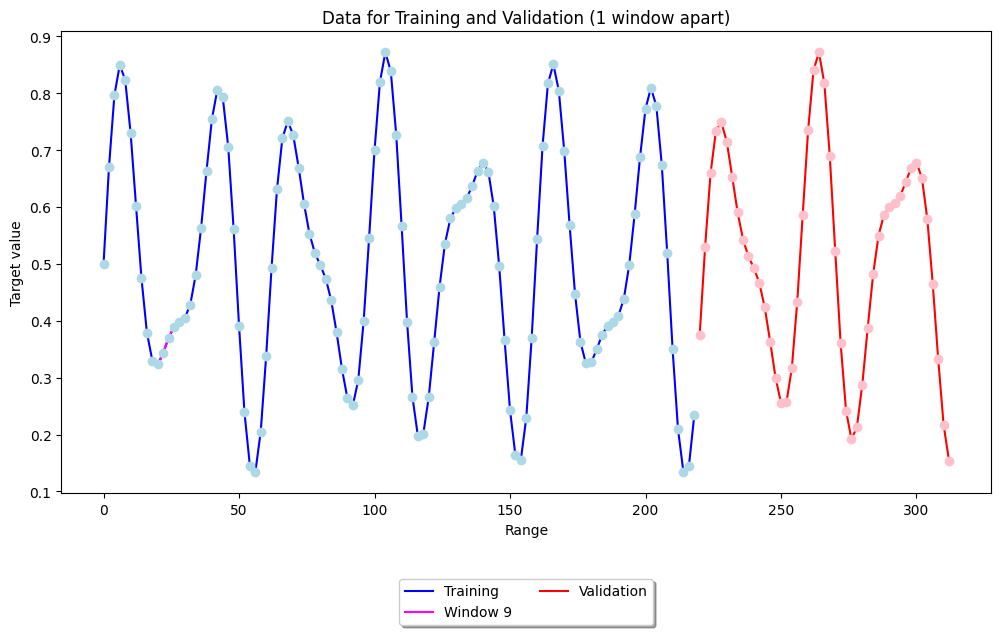



Sample Windows:

f([0,...,7]) ->
 [0.5, 0.59, 0.67, 0.74, 0.8, 0.83, 0.85, 0.85]
f([2,...,9]) ->
 [0.67, 0.74, 0.8, 0.83, 0.85, 0.85, 0.82, 0.78]
f([4,...,11]) ->
 [0.8, 0.83, 0.85, 0.85, 0.82, 0.78, 0.73, 0.67]
f([6,...,13]) ->
 [0.85, 0.85, 0.82, 0.78, 0.73, 0.67, 0.6, 0.54]
f([8,...,15]) ->
 [0.82, 0.78, 0.73, 0.67, 0.6, 0.54, 0.47, 0.42]



In [6]:
# Window to highlight
sel_wind = 9

# Plot prepared data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], color='blue', label='Training')
plt.plot(X_train_ts[sel_wind], y_train_ts[sel_wind], color='magenta', label='Window '+str(sel_wind))
plt.plot([xt[0] for xt in X_train_ts], [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], color='red', label='Validation')
plt.plot([xv[0] for xv in X_valid_ts], [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
# plt.plot(X_all, y_all, marker='o', color='lightblue', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

print(f'\n\nSample Windows:\n')
for i in range(5):
    print(f'f([{round(X_train_ts[i][0], 2)},...,{round(X_train_ts[i][-1], 2)}]) ->\n {[round(v, 2) for v in y_train_ts[i]]}')
print()

## Encoding TS windows
We can either quantize the TS values and rely on amplitude encoding (with RawFeatureVector),<br>
or we can use continuous TS values and utilize rotation encoding (with Z-Features or ZZ-Features).

Time series value quantization:
- The time series values will be mapped into a range of -100..+100
- Every value in the TS will be encoded relative to the previous value in terms of their difference
- The difference between values will be encoded into vn qubits, i.e. the sign and its bit representation
- The negative zero will be converted into an unsigned (positive) zero
- There are a few different ways of encoding the bit representation, e.g.
  
| <br>Type | <br>No of Bits | Sign<br>Location | Value<br>Range | Example<br>Value | Value<br>Rep |     | Example<br>Sequence | Sequence<br>Rep |
| --- | :-: | :-: | --- | :-: | --- | --- | --- | --- |
| Binary | 5 bits | bit 0 (right) | [-15 ... +15] | -5 | [0 1 0 1 1] || [-5, 5, 1] | [[0 1 0 1 1] [0 1 0 1 0] [0 0 0 1 0]]|
| Unary | 8 bits | bit 0 (right) | [-7 ... +7] | -5 | [0 0 1 0 0 0 0 1] || [-5, 5, 1] |[[0 0 1 0 0 0 0 1] [0 0 1 0 0 0 0 0] [0 0 1 0 0 0 1 0]]|
| Angle | 1 real | real sign | [-1.0 ... +1.0] | -0.5 | -0.5 || [-0.5, 0.7, 1] | [-0.5 0.7 1] |


### Utilities

In [7]:
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_state_city, plot_state_paulivec
from qiskit import Aer

In [8]:
# Converts measurements amplitudes a and b in a|0>+b|1> into bloch vector
def convert_amps_to_xyz(a, b):
    x = 2*np.real(a*np.conjugate(b))
    y = 2*np.imag(b*np.conjugate(a))
    z = a*np.conjugate(a)-b*np.conjugate(b)
    return [x, y, z] 

# Apply map recursively
round3 = lambda n: round(n, 3)
sq = lambda n: round(n**2, 3)

def nest_map(f, o):
    if type(o) == float or type(o) == int:
        return f(o)
    elif type(o) == list:
        return list(map(lambda x: nest_map(f, x), o))
    elif isinstance(o, np.ndarray):
        return nest_map(f, list(o))
    else:
        return o

nest_map(sq, [2.987, np.array([2.8973, 3.0943]), 1.9832, 3.12167])

[8.922, [2.8973, 3.0943], 3.933, 9.745]

### Angle encoding

In [9]:
### Angle encoding of a TS value relative to the previous value
#   prev_raw: Previous value in [-1..+1] range
#   next_raw: Next value in [-1..+1] range
#   optional scaler=np.pi/2: Number scaler 
#   optional err_range=0/0.05: allows range scaling to cater for accumulating errors
#   returns: Encoding of the next value relative to the previous value
def ts_relang_encode_val(prev_raw, next_raw, scaler=np.pi/2, err_range=0):
    prev = prev_raw
    next = next_raw
    val = (next-prev) * scaler * (1 - 2 * err_range)
    return val

### Decoding
def ts_relang_decode_val(prev_raw, next_code, scaler=np.pi/2, err_range=0):
    return prev_raw + next_code / (scaler * (1 - 2 * err_range))

### Normalises the value to 1 (not required with angle encoding)
def ts_relang_norm_val(next_code):
    norm_code = next_code
    return norm_code

### Print encoding and decoding for testing
def print_ts_relang_encode_val(p, n):
    val = round(ts_relang_encode_val(p, n), 3)
    if val == 0:
        print(f'{(p, n)} -> {val} (π*{0.0})')
    else:
        print(f'{(p, n)} -> {val} (π/{round(np.pi / val, 3)})')
    
def print_ts_relang_decode_val(p, n):
    if n == 0:
        print(f'({p}, {round(n, 3)} (π*{0.0})) -> {ts_relang_decode_val(p, n)}')
    else:
        print(f'({p}, {round(n, 3)} (π/{round(np.pi / n, 3)})) -> {round(ts_relang_decode_val(p, n), 3)}')

def print_ts_relang_norm_val(p):
    print(f'{(round(p, 3))} -> {round(ts_relang_norm_val(p), 3)}')


### Tests
print('Encoding:')
print_ts_relang_encode_val(0, 1)
print_ts_relang_encode_val(0.5, 0.5)
print_ts_relang_encode_val(0.2, 0.7)
print_ts_relang_encode_val(0.7, 0.2)
print_ts_relang_encode_val(0.7, 1.2) # Out of [0..pi] range
print_ts_relang_encode_val(0.2, -0.7) # Out of [0..pi] range

print('\nDecoding:')
print_ts_relang_decode_val(0, np.pi)
print_ts_relang_decode_val(0.5, 0*np.pi)
print_ts_relang_decode_val(0.2, np.pi/2)
print_ts_relang_decode_val(0.7, -np.pi/2)
print_ts_relang_decode_val(0.7, np.pi/2) # Out of [0..pi] range
print_ts_relang_decode_val(0.2, -0.9*np.pi) # Out of [0..pi] range

print('\nNormalise Encoding:')
print_ts_relang_norm_val(1.5*np.pi)
print_ts_relang_norm_val(-0.5*np.pi)

Encoding:
(0, 1) -> 1.571 (π/2.0)
(0.5, 0.5) -> 0.0 (π*0.0)
(0.2, 0.7) -> 0.785 (π/4.002)
(0.7, 0.2) -> -0.785 (π/-4.002)
(0.7, 1.2) -> 0.785 (π/4.002)
(0.2, -0.7) -> -1.414 (π/-2.222)

Decoding:
(0, 3.142 (π/1.0)) -> 2.0
(0.5, 0.0 (π*0.0)) -> 0.5
(0.2, 1.571 (π/2.0)) -> 1.2
(0.7, -1.571 (π/-2.0)) -> -0.3
(0.7, 1.571 (π/2.0)) -> 1.7
(0.2, -2.827 (π/-1.111)) -> -1.6

Normalise Encoding:
4.712 -> 4.712
-1.571 -> -1.571


In [10]:
### Encoding the entire data set
def ts_relang_encode(wind_set, scaler=np.pi):
    encoded_set = []
    for wind_idx in range(wind_set.shape[0]):
        wind = wind_set[wind_idx]
        encoded_wind = []
        prev = wind[0]
        for val_idx in range(wind.shape[0]):
            val = wind[val_idx]
            encoded_val = ts_relang_encode_val(prev, val, scaler)
            encoded_wind.append(encoded_val)
            prev = val
        encoded_set.append(encoded_wind)
    org_wind_start = np.array([w[0] for w in wind_set])
    return np.array(encoded_set), org_wind_start

### Encoding the entire data set
def ts_relang_decode(org_wind_start, encoded_wind_set, scaler=np.pi):
    decoded_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        decoded_wind = []
        prev = org_wind_start[wind_idx]
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            decoded_val = ts_relang_decode_val(prev, encoded_val, scaler)
            decoded_wind.append(decoded_val)
            prev = decoded_val
        decoded_set.append(decoded_wind)
    return np.array(decoded_set)

### Normalise the entire data set
def ts_relang_norm(encoded_wind_set):
    norm_wind_set = []
    for wind_idx in range(encoded_wind_set.shape[0]):
        wind = encoded_wind_set[wind_idx]
        norm_wind = []
        for val_idx in range(wind.shape[0]):
            encoded_val = wind[val_idx]
            norm_val = ts_relang_norm_val(encoded_val)
            norm_wind.append(norm_val)
        norm_wind_set.append(norm_wind)
    return np.array(norm_wind_set)

### Padding not required in angle encoding, however, we'll add zeroes if needed
### Converting encoded windows into a list of circuit parameters by padding them to fit amplitude encoding
def ts_relang_wind2params(enc_set, padding):
    # wind_bits = enc_set[0].shape[0] * enc_set[0].shape[1]
    # ts_params = [list(np.reshape(enc_wind, (wind_bits, ))) + [0]*padding for enc_wind in enc_set]
    return np.array(enc_set)

### Converting list of circuit parameters to encoded windows by removing padding
def ts_relang_params2wind(params, padding):
    # flat_windows = list([param[:-padding] for param in params])
    # return np.reshape(flat_windows, (len(params), wind_size, enc_digits))
    return params

### Preparing data for training

In [11]:
y_train_enc, org_train_start = ts_relang_encode(y_train_ts)

### Testing
y_train_dec = ts_relang_decode(org_train_start, ts_relang_norm(y_train_enc))
print('Training windows before encoding:\n', y_train_ts[5:8])
print('\nTraining windows after encoding:\n', y_train_enc[5:8])
print('\nTraining windows org start:\n', org_train_start[5:8])
print('\nTraining windows after decoding:\n', y_train_dec[5:8])

Training windows before encoding:
 [[0.72914563 0.66700956 0.60080307 0.53516537 0.47427369 0.42152034
  0.3792793  0.34878154]
 [0.60080307 0.53516537 0.47427369 0.42152034 0.3792793  0.34878154
  0.33010704 0.32229002]
 [0.47427369 0.42152034 0.3792793  0.34878154 0.33010704 0.32229002
  0.32352248 0.33143204]]

Training windows after encoding:
 [[ 0.         -0.19520623 -0.20799382 -0.20620692 -0.19129685 -0.16572954
  -0.13270414 -0.09581154]
 [ 0.         -0.20620692 -0.19129685 -0.16572954 -0.13270414 -0.09581154
  -0.05866766 -0.02455791]
 [ 0.         -0.16572954 -0.13270414 -0.09581154 -0.05866766 -0.02455791
   0.0038719   0.0248486 ]]

Training windows org start:
 [0.72914563 0.60080307 0.47427369]

Training windows after decoding:
 [[0.72914563 0.66700956 0.60080307 0.53516537 0.47427369 0.42152034
  0.3792793  0.34878154]
 [0.60080307 0.53516537 0.47427369 0.42152034 0.3792793  0.34878154
  0.33010704 0.32229002]
 [0.47427369 0.42152034 0.3792793  0.34878154 0.33010704 0.3

In [12]:
wind_qubits = wind_size
wind_padding = 0

print(f'Trainig TS windows properties\n')
print(f'Each TS window has {wind_size} values, e.g. y_train_ts[6]={[round(x, 3) for x in y_train_ts[6]]}')
print(f'Each TS window requires {wind_qubits} qubits to encode with angle encoding')
print(f'Each TS window parameters require window padding with extra {wind_padding} values')
# print(f'Example of parameter padding for y_train_ts[6] ->')
# print(f' {list(np.reshape(y_train_enc[6], (wind_bits, )))} + {[0]*wind_padding} =')
# print(f' {list(ts_relbin_wind2params(y_train_enc[6:7], wind_padding)[0])}')
# print(f'\nSample of padded window parameters y_train_enc[5:8]:')
# params_sample = ts_relbin_wind2params(y_train_enc[5:8], wind_padding)
# for param in params_sample:
#     print(f' {list(param)}')

Trainig TS windows properties

Each TS window has 8 values, e.g. y_train_ts[6]=[0.601, 0.535, 0.474, 0.422, 0.379, 0.349, 0.33, 0.322]
Each TS window requires 8 qubits to encode with angle encoding
Each TS window parameters require window padding with extra 0 values


## Building and training a Quantum Autoencoder

First, we implement IBM's Qiskit to build our Quantum Autoencoder. We first begin by importing in the necessary libraries and fixing the seed.

In [13]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap
from qiskit.quantum_info import Statevector
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram, plot_state_city, plot_state_paulivec
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit import Parameter

algorithm_globals.random_seed = 42

### Sequence encoder
The sequence is encoded as a series of angle rotations

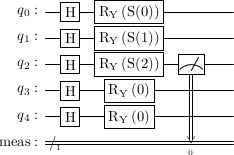


Input parameters for the sequence:  [Parameter(S(0)), Parameter(S(1)), Parameter(S(2))]


In [14]:
### Creates a circuit encoding a sequence 
#   - Adds H gates to position each qubit at a "zero" position
#   - Each sequence value y-rotates the qubit state either up (negative) or down (positive)
#   - Use only as many input values as the number of qubits, if not enough provided zero rotations are added
#   qubits_no: Number of qubits
#   input_no: Number of values in a sequence
#   optional classreg=False: Flag indicating if a classical register is to be added
#   optional meas_q=None: Indicates the qubit to be measured, active only when classreg=True
#   returns: Circuit encoding a sequence
def sequence_encoder(qubit_no, input_no, classreg=False, meas_q=None):
    
    used_sgates = 0
    label = 'S'

    qr = QuantumRegister(qubit_no, 'q')
    cr = ClassicalRegister(1, 'meas')
    if classreg:
        seq = QuantumCircuit(qr, cr, name='sequence')
    else:
        seq = QuantumCircuit(qr, name='sequence')
    SParams = []

    # Data-encoding circuit block, packs different input vars
    for q in range(qubit_no):
        seq.h(q)
        if q > input_no:
            seq.ry(0, q)
        else:
            param_x = Parameter(label+'('+str(q)+')') if used_sgates < input_no else 0
            seq.ry(param_x, q)
        used_sgates += 1

    if classreg and meas_q != None:
        seq.measure(meas_q, 0)

    return seq, seq.parameters[:]

# Test a sample sequence encoder
test_seq, inp_params = sequence_encoder(5, 3, classreg=True, meas_q=2)
print('\n')
display(test_seq.draw(output='latex', style="iqp", fold=False, scale=0.7))
print('\nInput parameters for the sequence: ', inp_params)

### Creation of an ansatz

The selectede ansatz is the Qiskit RealAmplitude ansatz (2-local circuit) - the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between qubits. 

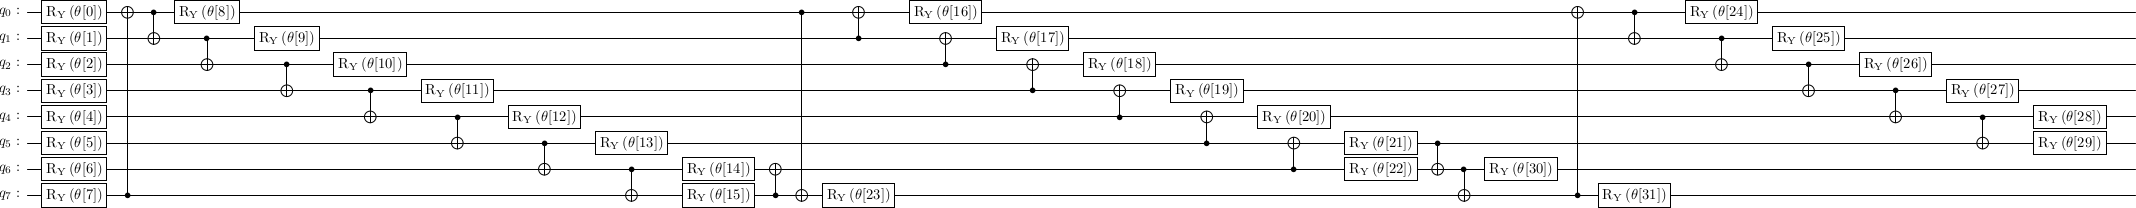


Number of ansatz parameters: 32



In [15]:
def ansatz(num_qubits, reps=3, ent='circular'):
    return RealAmplitudes(num_qubits, reps=reps, entanglement=ent)

test_ansatz = ansatz(wind_qubits, reps=3, ent='sca') # linear, reverse_linear, full, circular, sca
print('\n')
display(test_ansatz.decompose().draw("latex", style="iqp", scale=0.7, fold=False))
print(f'\nNumber of ansatz parameters: {len(test_ansatz.parameters)}\n')

### Encoder development
We now apply the ansatz as an Encoder to the state we wish to compress. 
We divide our initial $n+k$ qubit state into a $n$ qubit latent state and $k$ qubit trash space. 
We must also include a $k$ qubit reference space in our circuit, as well as $1$ auxiliary qubit to perform the swap test between the reference and trash states. 
We will therefore have a total of $n + k + k + 1$ qubits and $1$ classical register in our circuit.

After initializing our state, we apply our parametrized circuit.

Following this, we then split our initial state into the latent space (the compressed state) and trash space (the part of the state we will disregard) 
and perform the swap test between the reference state and the trash space. 
The last qubit is then measured to determine the fidelity between the reference and trash states.  
A pictorial representation of this is given below in the following figure. 

We define a function below to implement the above circuit configuration to the $5$ qubit domain wall state $|00111\rangle$ and plot an example below. Here qubits $5$ and $6$ are the reference state, $0, 1, 2, 3, 4$ are the initial state we wish to compress and qubit $7$ is our auxiliary qubit which is used in the swap test. We also include a classical register to measure the results of qubit $7$ in the swap test. 

In [16]:
num_trash = 2
num_latent = wind_qubits-num_trash


Example autoencoder circuit:



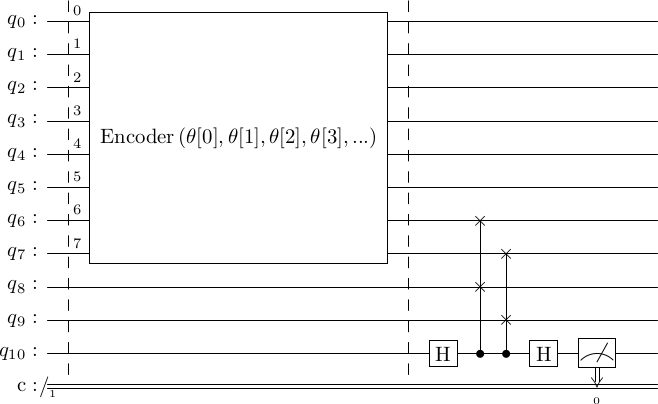


Number of trash qubits k=2
Number of latent qubits n=6



In [17]:
def auto_encoder_circuit(num_latent, num_trash, reps=4, ent='circular'):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    anz = ansatz(num_latent + num_trash, reps=reps, ent=ent)
    anz.name = 'Encoder'
    circuit = QuantumCircuit(qr, cr)
    circuit.barrier()
    circuit.compose(anz, range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

test_ae = auto_encoder_circuit(num_latent, num_trash)
print('\nExample autoencoder circuit:\n')
display(test_ae.draw("latex", style="iqp", scale=1))
print(f'\nNumber of trash qubits k={num_trash}')
print(f'Number of latent qubits n={num_latent}\n')

**Figure: Example of a Quantum Autoencoder in the training process**

Note that we use the swap test to determine the fidelity between the trash and reference space. 

In order to reconstruct the original input state, we must apply the adjoint of our parametrized circuit after the swap test.<br>
However, during training, we are only interested in the trash state and the reference state.<br>
We can therefore exclude the gates following compression until we wish to reconstruct our initial input. 

After building our Quantum Autoencoder, the next step is to train our Quantum Autoencoder to compress the state and maximize the cost function and determine the parameters $\theta$. 

### Building a full quantum encoder
After encoding our TS windows into $(n+k)$ qubits, we begin to train our Quantum Autoencoder to compress this state into $k$ qubits.<br>
We will write a cost function based on the Swap Test between the trash and latent space.<br>
Note that the input state and trash space contain the same amount of qubits. 

Let's input one of our windows and see our circuit for the Autoencoder below. 

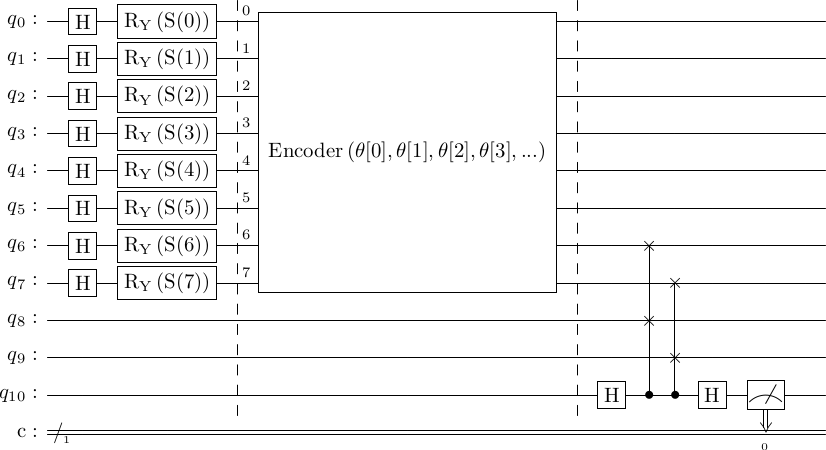


#Inputs: 8 (110, 8)
#Weights: 32



In [18]:
reps=3
ent='sca' # linear, reverse_linear, full, circular, sca

fm_qc, _ = sequence_encoder(num_latent + num_trash, wind_size)
ae_qc = auto_encoder_circuit(num_latent, num_trash, reps=reps, ent=ent)
wind_train_params = ts_relang_wind2params(y_train_enc, wind_padding)

trained_ae_qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
trained_ae_qc = trained_ae_qc.compose(fm_qc, range(num_latent + num_trash))
trained_ae_qc = trained_ae_qc.compose(ae_qc)

print('\n')
display(trained_ae_qc.draw("latex", style="iqp", scale=1))
print('\n#Inputs:', len(fm_qc.parameters), wind_train_params.shape)
print('#Weights:', len(ae_qc.parameters))
print()

Again, we can see the swap test being performed on the selected qubits to determine the value of our cost function.

### The entire QAE (sample only)

The full Autoencoder consists of both the Encoder and Decoder, which is simply an inverted Encoder. 
Both the Encoder and Decoder can be initialised using the same parameters obtained from the Encoder (plus swap test) training.
By applying the full QAE circuit to a test dataset, we can then determine the model accuracy.

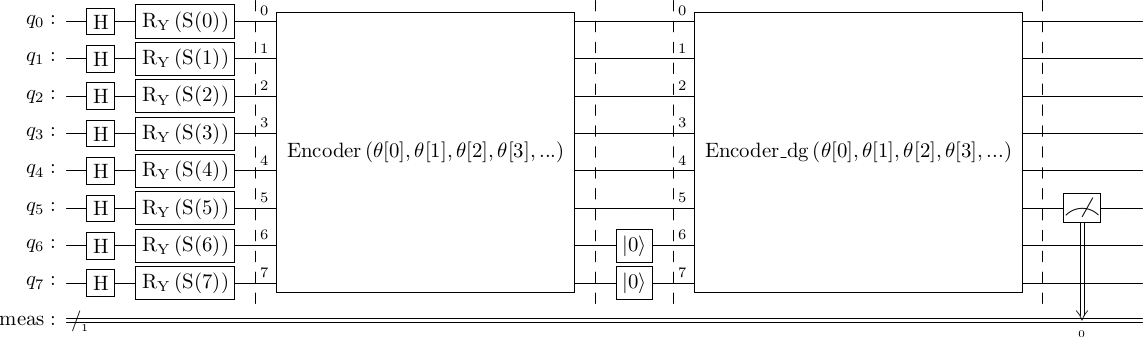


#QAE Input Parameters: 8 (110, 8)
#Encoder/Decoder Weights: 32
#QAE Total Weights: 40



In [19]:
# Full QAE
def qae(fm_qc, lat_no, trash_no, reps=3, ent='sca', classreg=False, meas_q=None):

    # Prepare a circuit
    qr = QuantumRegister(lat_no + trash_no, 'q')
    cr = ClassicalRegister(1, 'meas')
    # qae_qc = QuantumCircuit(lat_no + trash_no, 1)
    if classreg:
        qae_qc = QuantumCircuit(qr, cr, name='qae')
    else:
        qae_qc = QuantumCircuit(qr, name='qae')

    # Create all QAE components
    qae_qc = qae_qc.compose(fm_qc)
    ansatz_qc = ansatz(lat_no + trash_no, reps=reps, ent=ent)
    ansatz_qc.name = 'Encoder'

    # Create a circuit
    qae_qc.barrier()
    qae_qc = qae_qc.compose(ansatz_qc)
    qae_qc.barrier()
    
    for i in range(num_trash):
        qae_qc.reset(lat_no + i)
    
    qae_qc.barrier()
    ansatz_inv_qc = ansatz_qc.inverse()
    qae_qc = qae_qc.compose(ansatz_inv_qc)

    # Add optional measurement
    if classreg and meas_q != None:
        qae_qc.barrier()
        qae_qc.measure(meas_q, 0)

    return qae_qc, ansatz_qc

qae_qc, an_qc = qae(fm_qc, num_latent, num_trash, reps=reps, ent=ent, classreg=True, meas_q=5)

print('\n')
display(qae_qc.draw("latex", style="iqp", scale=1))
print('\n#QAE Input Parameters:', len(fm_qc.parameters), wind_train_params.shape)
print('#Encoder/Decoder Weights:', len(an_qc.parameters))
print('#QAE Total Weights:', len(qae_qc.parameters))
print()

## Model training

**Sampler** needs to be imported from *qiskit_aer.primitives*.
Unfortunately, *qiskit-aer-gpu 0.12.2* has a bug, which has been fixed 
in the next version *qiskit-aer-gpu 0.13.0*, see notes in the version table.

In [20]:
# from qiskit.primitives import Sampler # For "CPU", ignores device="GPU" option
# seed = 2023
# device = 'CPU'
# sampler = Sampler()
# sampler.set_options(method='statevector')
# sampler.set_options(device=device)
# sampler.set_options(seed=seed)
# sampler.options

In [21]:
from qiskit_aer.primitives import Sampler as AerSampler # For device="GPU" option
seed = 2023
device = 'GPU'
sampler = AerSampler(
    backend_options={'method':'statevector', 'device' : device, 'cuStateVec_enable' : True},
    run_options={'seed': seed, 'shots': 1000},
    transpile_options={"seed_transpiler": seed},
)

In [22]:
def identity_interpret(x):
    return x

first_only = lambda x: x % 2

qnn = SamplerQNN(
    circuit=trained_ae_qc,
    input_params=fm_qc.parameters,
    weight_params=ae_qc.parameters,
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler
)

We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit's CircuitQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [23]:
def cost_func_tswind(params_values):
    probabilities = qnn.forward(wind_train_params, params_values)
    cost = np.sum(probabilities[:, 1]) / wind_train_params.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Cost function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cost function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [24]:
print('#Inputs:', len(fm_qc.parameters), wind_train_params.shape)
print('#Weights:', len(ae_qc.parameters))
print()

#Inputs: 8 (110, 8)
#Weights: 32



In [25]:
saved_starting_point = False
init_file_name = f'qae_angle_{ent}_reps{reps}_p{len(ae_qc.parameters)}_init.json'

if saved_starting_point:
    ### Using previously saved init point
    print(f'Using previously saved init parameters from file "{init_file_name}"')
    epochs = 50 
    with open(init_file_name, 'r') as f:
        initial_point = json.load(f)
else:
    ### Using a random init point
    print(f'Random init parameters to be saved to file "{init_file_name}"')
    epochs = 300 
    initial_point = algorithm_globals.random.random(ae_qc.num_parameters)

Random init parameters to be saved to file "qae_angle_sca_reps3_p32_init.json"


By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

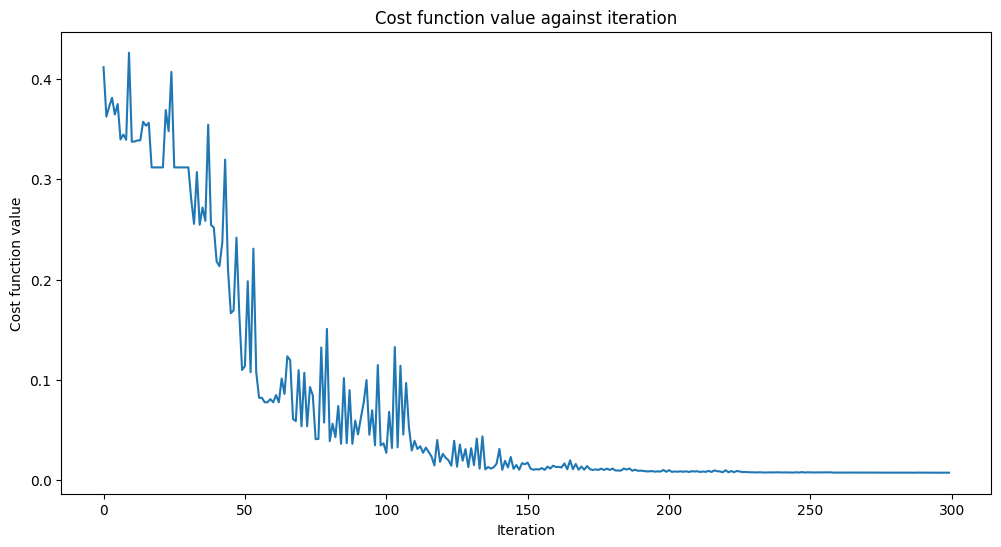

In [26]:
opt = COBYLA(maxiter=epochs)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_tswind, x0=initial_point)
elapsed = time.time() - start

In [27]:
# Print run statistics
print(f'{device} Fit ('+
      f'{wind_train_params.shape[0]} samples, '+
      f'{wind_train_params.shape[1]} qubits, '+
      f'{len(ae_qc.parameters)} params): '+
      f'{round(opt_result.fun, 5)} min cost, '+
      f'{elapsed:0.2f} sec')

GPU Fit (110 samples, 8 qubits, 32 params): 0.00746 min cost, 51.65 sec


### Statistics

***furies-vengence: ASUS 64Gb RAM***
- CPU Intel i9, 24 cores, 32 threads, 2.2-3.0-4.3-5.4GHz
- GPU NVIDIA GTX 4090, 16384 CUDA Cores, 24 Gb RAM, CUDA V12.3, NVIDIA Driver 545.29.06

GPU Fit (110 samples, 8 qubits, 32 params): **0.00769 min cost, 51.56 sec**<br/>
CPU Fit (110 samples, 8 qubits, 32 params): **0.0051 min cost, 108.36 sec**

***basilisk: Lenovo 32Gb RAM***
- CPU Intel i7, 4 cores, 8 threads, 2.8GHz - No GPU

CPU Fit (110 samples, 8 qubits, 32 params): **0.00744 min cost, 226.05 sec**

In [28]:
to_be_saved_starting_point = False

if to_be_saved_starting_point:
    ## Saving the initialisation point
    with open(init_file_name, 'w') as f:
        json.dump(opt_result.x.tolist(), f)
    print(f'Saved optimum parameters as the future starting point, in: {init_file_name}')

Looks like the training converged - expected final cost below 0.05!

**<font color='red'>However, it still needs to be tested to check if it makes any sense!</font>**

## Model testing

### Preparing data for testing

In [29]:
### Encoding all test windows
y_valid_enc, org_valid_start = ts_relang_encode(y_valid_ts)

In [30]:
### Testing validation windows

y_valid_dec = ts_relang_decode(org_valid_start, y_valid_enc)

print('Validation windows before encoding:\n', y_valid_ts[0:8])
print('\nValidation windows after encoding:\n', y_valid_enc[0:8])
print('\nValidation windows org start:\n', org_valid_start[0:8])
print('\nValidation windows after decoding:\n', y_valid_dec[0:8])

# params_sample = ts_relang_wind2params(y_valid_enc[5:8], 0)
# winds_recovered = ts_relang_params2wind(params_sample, 0)

# print(f'\nSample of padded window parameters y_valid_enc[5:8]:')
# for param in params_sample:
#     print(f' {list(param)}')
# print(f'\nValidation windows after recovery:\n{winds_recovered}\n')

# print(f'\nNumber of validation windows: {y_valid_dec.shape[0]}')

Validation windows before encoding:
 [[0.37557775 0.45396566 0.53034154 0.59994087 0.65881311 0.70409843
  0.73419579 0.74881005]
 [0.53034154 0.59994087 0.65881311 0.70409843 0.73419579 0.74881005
  0.7488778  0.73638325]
 [0.65881311 0.70409843 0.73419579 0.74881005 0.7488778  0.73638325
  0.7140858  0.68518912]
 [0.73419579 0.74881005 0.7488778  0.73638325 0.7140858  0.68518912
  0.65298666 0.62051995]
 [0.7488778  0.73638325 0.7140858  0.68518912 0.65298666 0.62051995
  0.59028406 0.56400903]
 [0.7140858  0.68518912 0.65298666 0.62051995 0.59028406 0.56400903
  0.5425377  0.52581023]
 [0.65298666 0.62051995 0.59028406 0.56400903 0.5425377  0.52581023
  0.51295405 0.50246727]
 [0.59028406 0.56400903 0.5425377  0.52581023 0.51295405 0.50246727
  0.49247366 0.48101995]]

Validation windows after encoding:
 [[ 0.00000000e+00  2.46262893e-01  2.39941887e-01  2.18652752e-01
   1.84952582e-01  1.42268031e-01  9.45536522e-02  4.59120418e-02]
 [ 0.00000000e+00  2.18652752e-01  1.84952582e-0

## Model testing
Note that all components of a test circuit will be built in the testing process

### Running and analysing tests for the selected TS windows

In [31]:
### Select a backend

backend = Aer.get_backend('aer_simulator_statevector')
# backend = Aer.get_backend('aer_simulator')

In [32]:
### Select a collection of windows to test

sel_wind_set = list(range(30))
# sel_wind_set = [1, 2, 3, 4, 5, 10, 20, 21, 22, 23, 30]
# sel_wind_set = [1, 2, 5]
in_org_set = {}
in_meas_set = {}
out_reconstr_set = {}

print(f'Selected {len(sel_wind_set)} windows to process')

Selected 30 windows to process


In [33]:
### Calculate measured input data (for comparison) and reconstructed input data

for wind_idx in range(len(sel_wind_set)):

    sel_wind = sel_wind_set[wind_idx]
    # print(f'\nWindow {sel_wind}:\n')
    
    wind_valid_params = ts_relang_wind2params(y_valid_enc, 0)
    wind = wind_valid_params[sel_wind]

    # print(f'\tOriginal window:\t{[round(w, 3) for w in wind]}') 

    ### Find its original window state vector representation    
    org_meas = []
    for meas_q in range(len(wind)):
        # print(f'\nWindow {sel_wind}, Qubit {meas_q}')
        org_qc, _ = sequence_encoder(num_latent + num_trash, wind_size, classreg=True, meas_q=meas_q)
        org_qc = org_qc.assign_parameters(wind)

        job = backend.run(org_qc, shots=10000)
        result = job.result()
        counts = result.get_counts(org_qc)
        # print(f'Counts: {dict(sorted(counts.items()))}') 
        
        counts0 = counts['0'] if '0' in counts.keys() else 0
        counts1 = counts['1'] if '1' in counts.keys() else 0
        p0 = counts0/(counts0+counts1)
        p1 = counts1/(counts0+counts1)
        amp0 = np.sqrt(p0)
        amp1 = np.sqrt(p1)

        meas_angle = 2*np.arccos(amp0)-np.pi/2
        org_meas.append(meas_angle)
        
        # display(plot_histogram(counts, figsize=[4, 4]))
        # print(f'Counts: {dict(sorted(counts.items()))}') 
        # print(f'p(0) = {p0}, p(1) = {p1}, amp(0) = {round(amp0, 3)}, amp(1) = {round(amp1, 3)}')
        # print(f'Original Angle:  {round(wind[meas_q], 3)}, Recovered Angle: {round(meas_angle, 3)}')

    # print(f'\tMeasured original:\t{[round(o, 3) for o in org_meas]}')

    ### Find its resulting window state vector representation
    out_meas = []
    for meas_q in range(len(wind)):
        # print(f'\nWindow {sel_wind}, Qubit {meas_q}')
        param_values = np.concatenate((wind, opt_result.x))

        out_qc, _ = qae(fm_qc, num_latent, num_trash, reps=reps, ent=ent, classreg=True, meas_q=meas_q)     
        out_qc = out_qc.assign_parameters(param_values)
        out_qc = out_qc.decompose()
        # display(out_qc.draw(output='latex', style="iqp", scale=1, fold=False))
        
        job = backend.run(out_qc, shots=10000)
        result = job.result()
        counts = result.get_counts(out_qc)
        # print(f'Counts: {dict(sorted(counts.items()))}') 
        
        counts0 = counts['0'] if '0' in counts.keys() else 0
        counts1 = counts['1'] if '1' in counts.keys() else 0
        p0 = counts0/(counts0+counts1)
        p1 = counts1/(counts0+counts1)
        amp0 = np.sqrt(p0)
        amp1 = np.sqrt(p1)

        meas_angle = 2*np.arccos(amp0)-np.pi/2
        out_meas.append(meas_angle)
        
        # display(plot_histogram(counts, figsize=[4, 4]))
        # print(f'Counts: {dict(sorted(counts.items()))}') 
        # print(f'p(0) = {p0}, p(1) = {p1}, amp(0) = {round(amp0, 3)}, amp(1) = {round(amp1, 3)}')
        # print(f'Original Angle:  {round(wind[meas_q], 3)}, Recovered Angle: {round(meas_angle, 3)}')

    # print(f'\tRecovered original:\t{[round(o, 3) for o in out_meas]}')

    ### Add window results
    in_org_set[sel_wind] = list(wind)
    in_meas_set[sel_wind] = org_meas
    out_reconstr_set[sel_wind] = out_meas    

    print(f'Processed window: {sel_wind}')

Processed window: 0
Processed window: 1
Processed window: 2
Processed window: 3
Processed window: 4
Processed window: 5
Processed window: 6
Processed window: 7
Processed window: 8
Processed window: 9
Processed window: 10
Processed window: 11
Processed window: 12
Processed window: 13
Processed window: 14
Processed window: 15
Processed window: 16
Processed window: 17
Processed window: 18
Processed window: 19
Processed window: 20
Processed window: 21
Processed window: 22
Processed window: 23
Processed window: 24
Processed window: 25
Processed window: 26
Processed window: 27
Processed window: 28
Processed window: 29


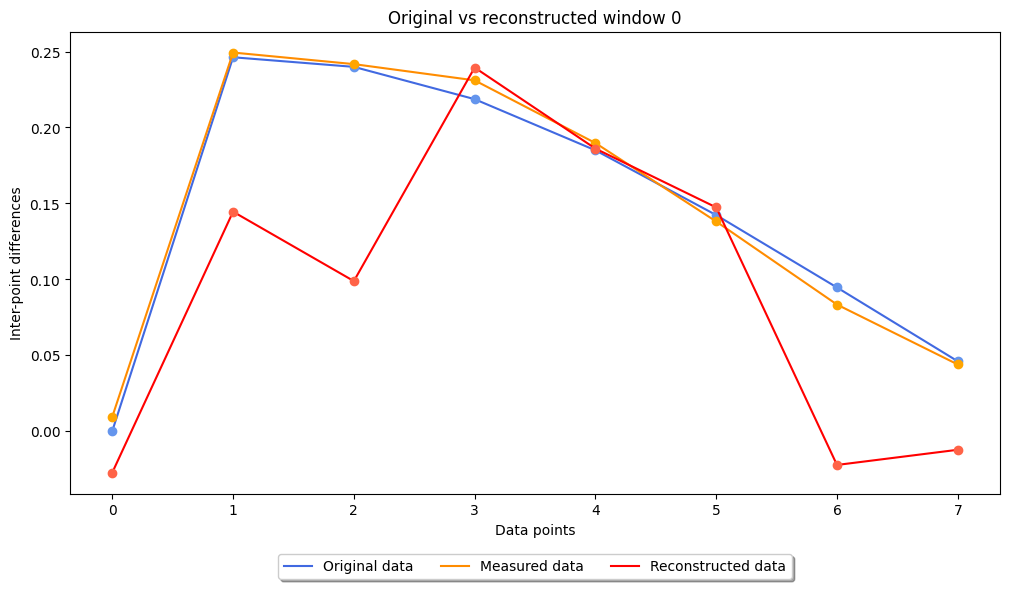

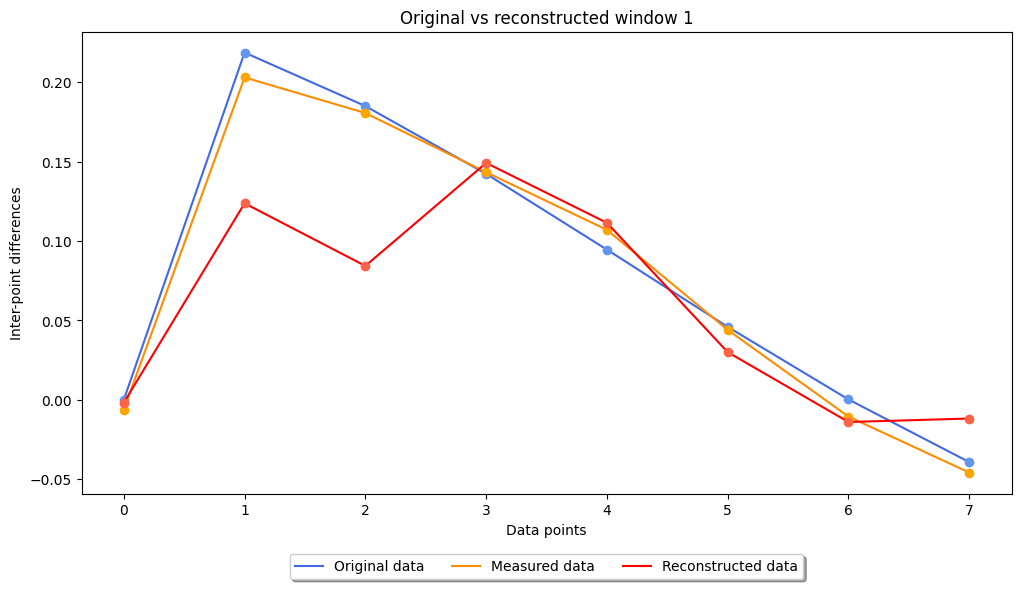

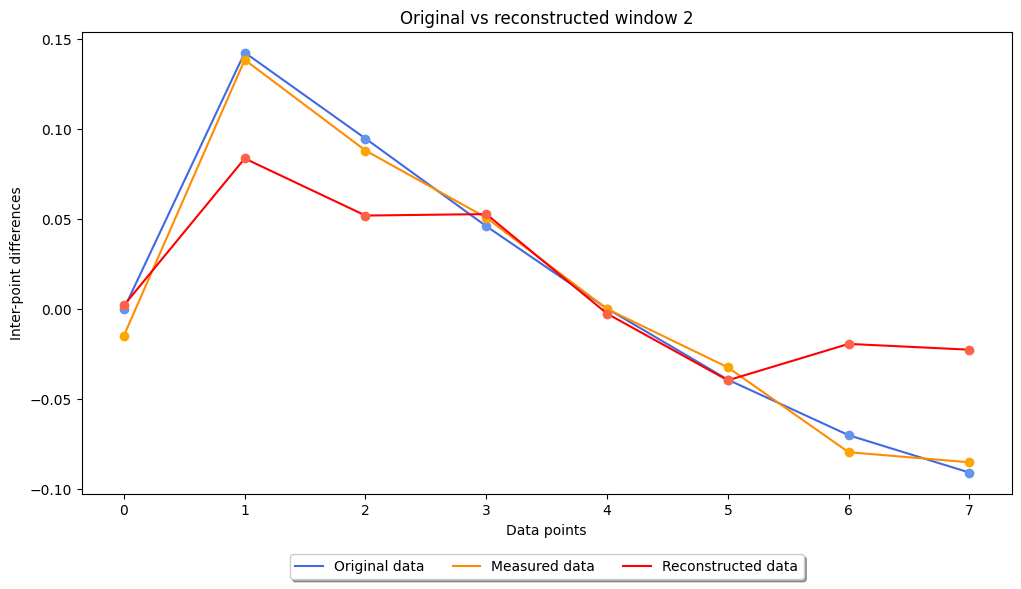

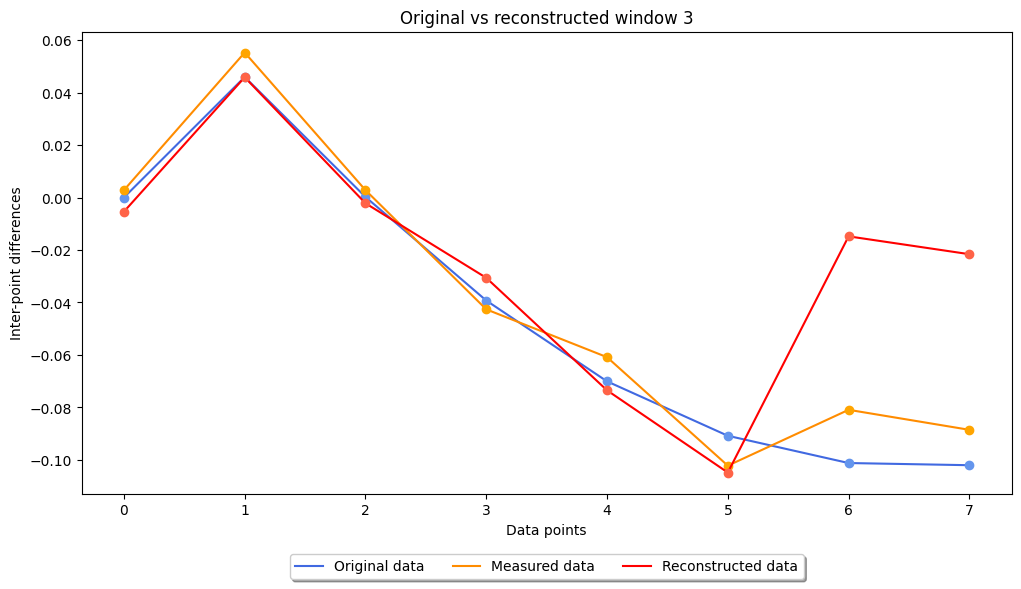

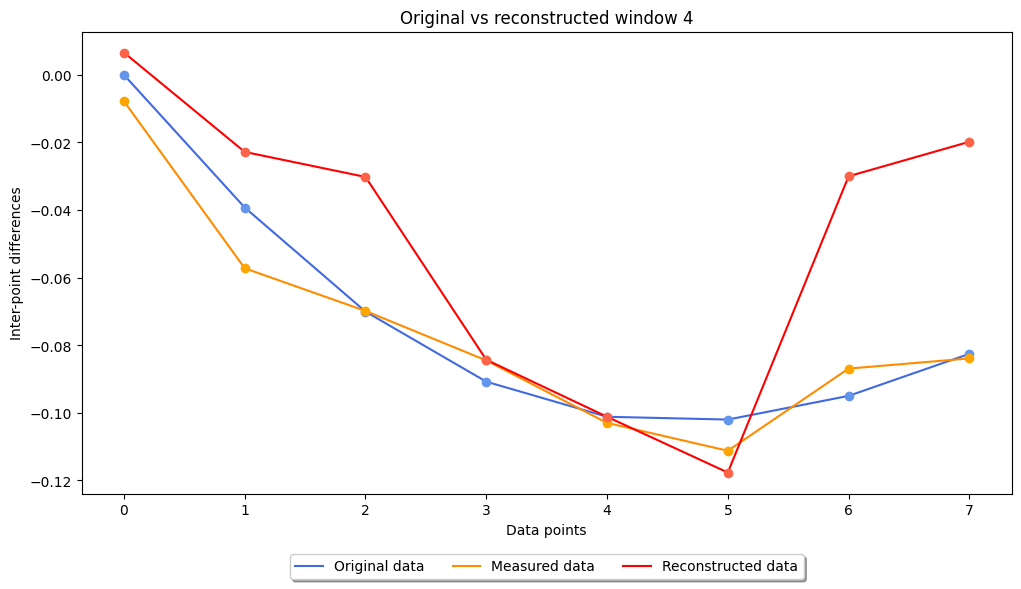

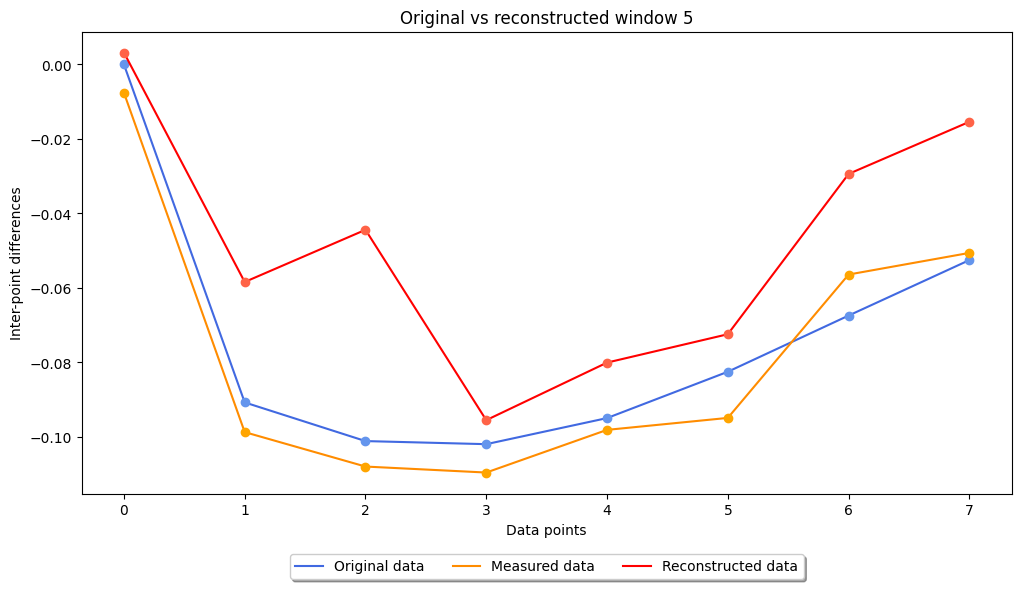

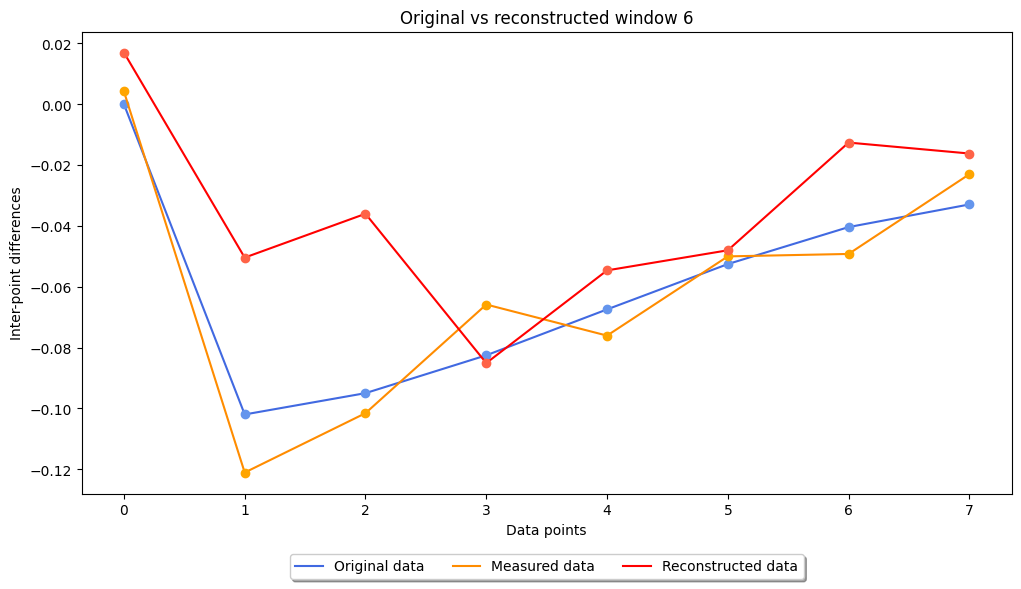

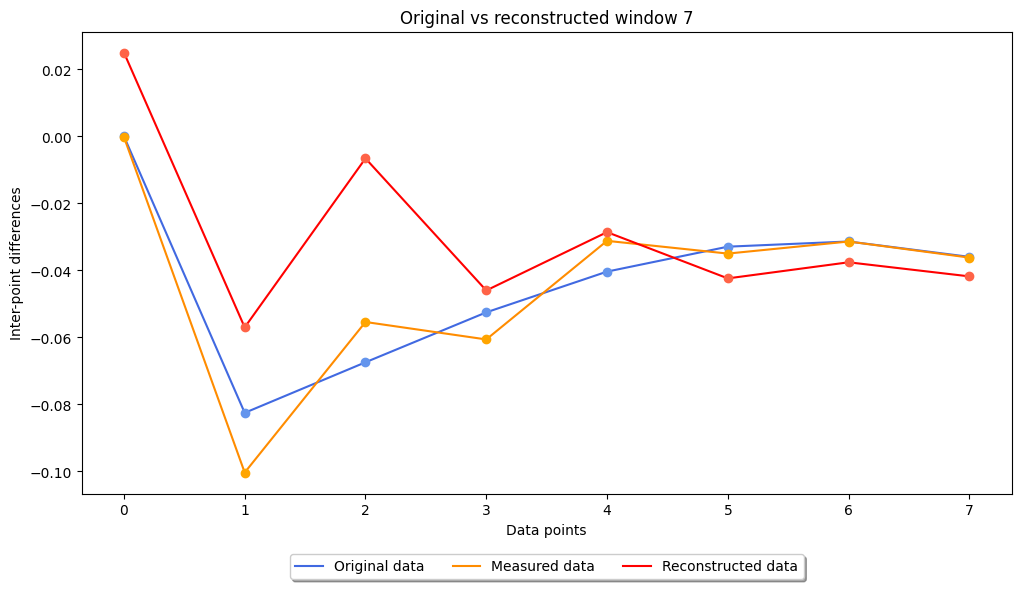

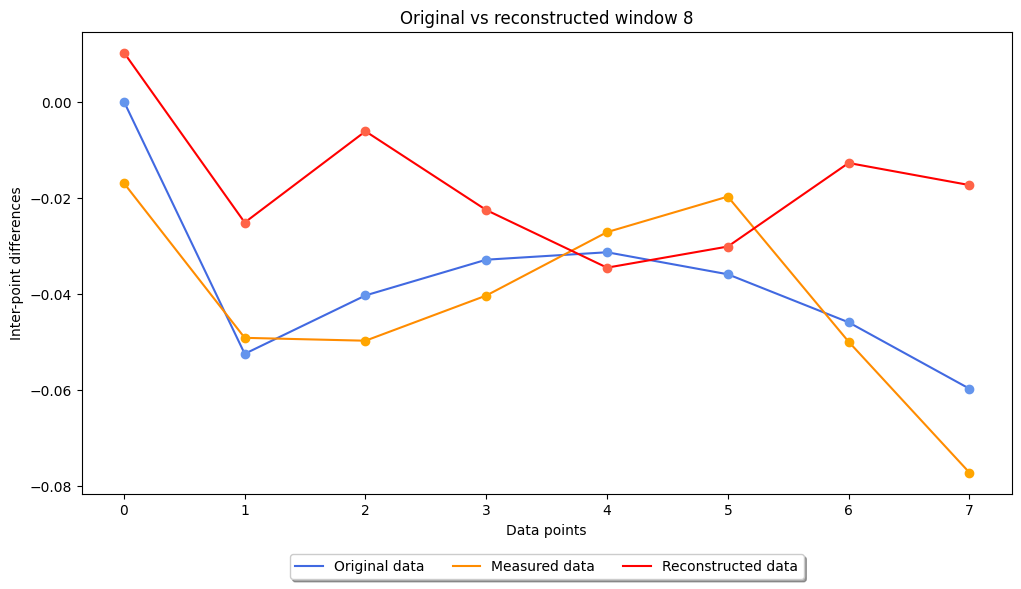

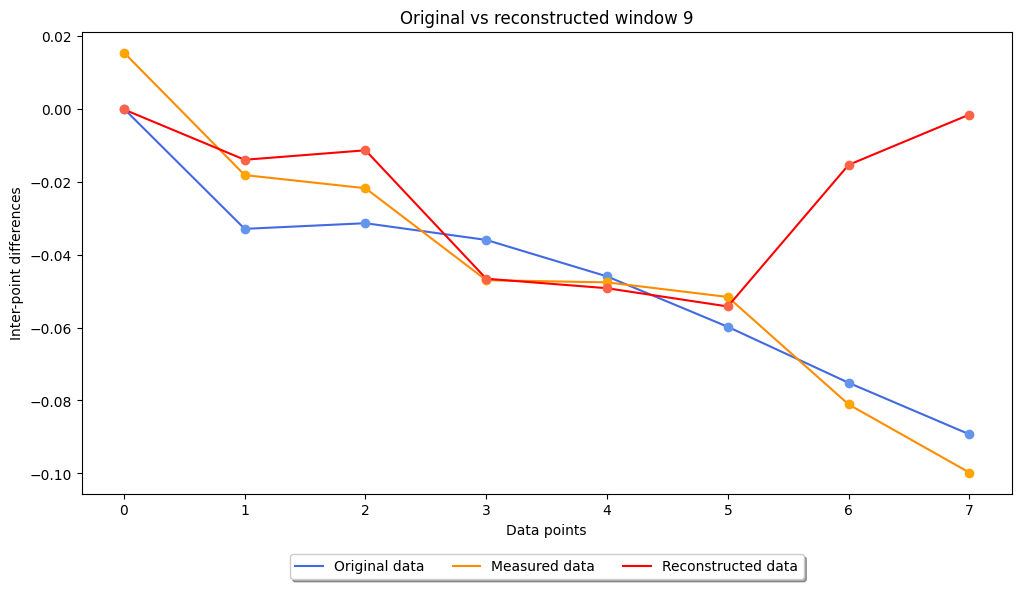

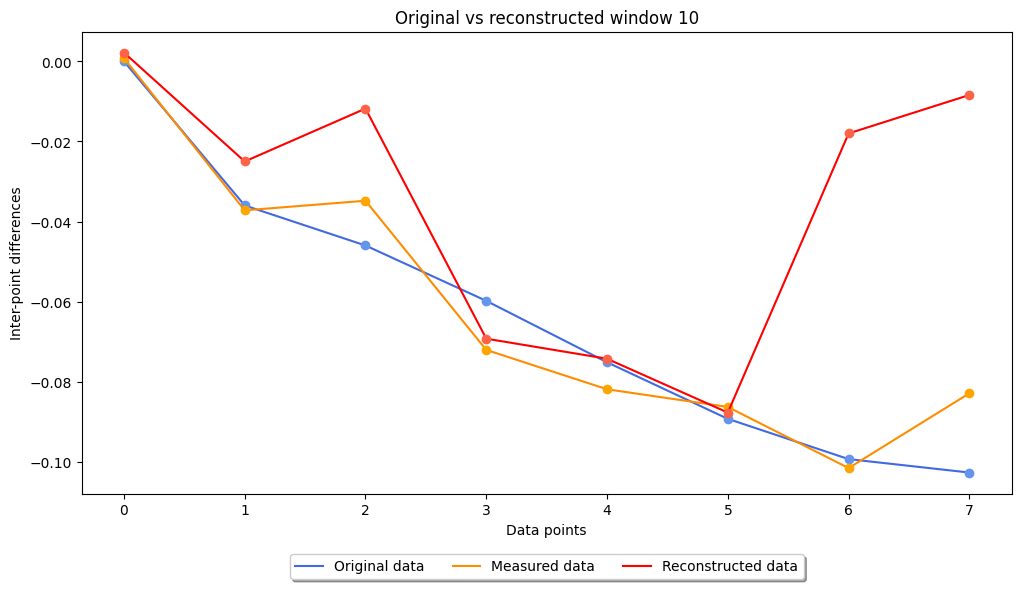

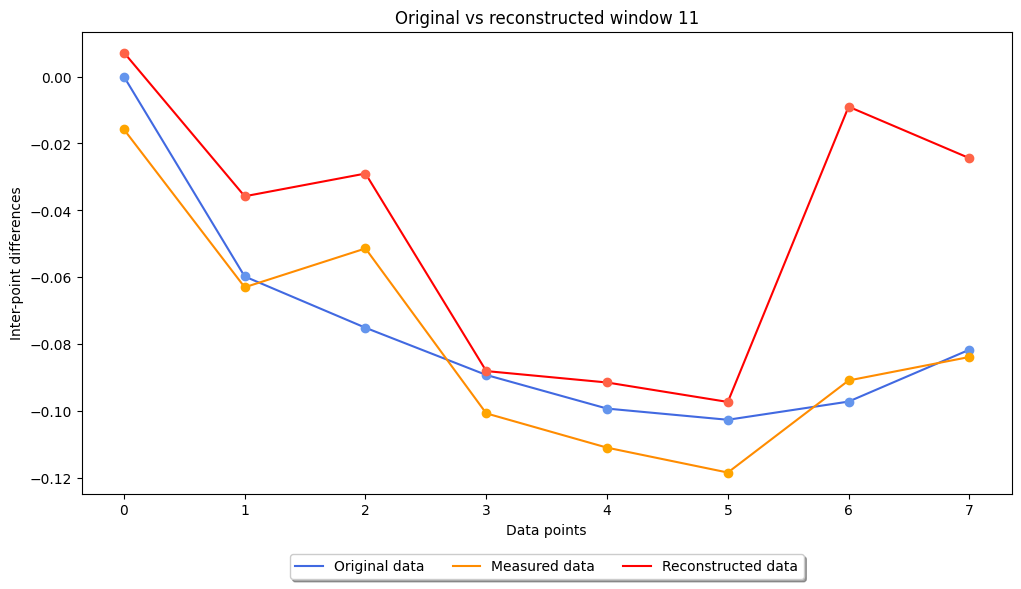

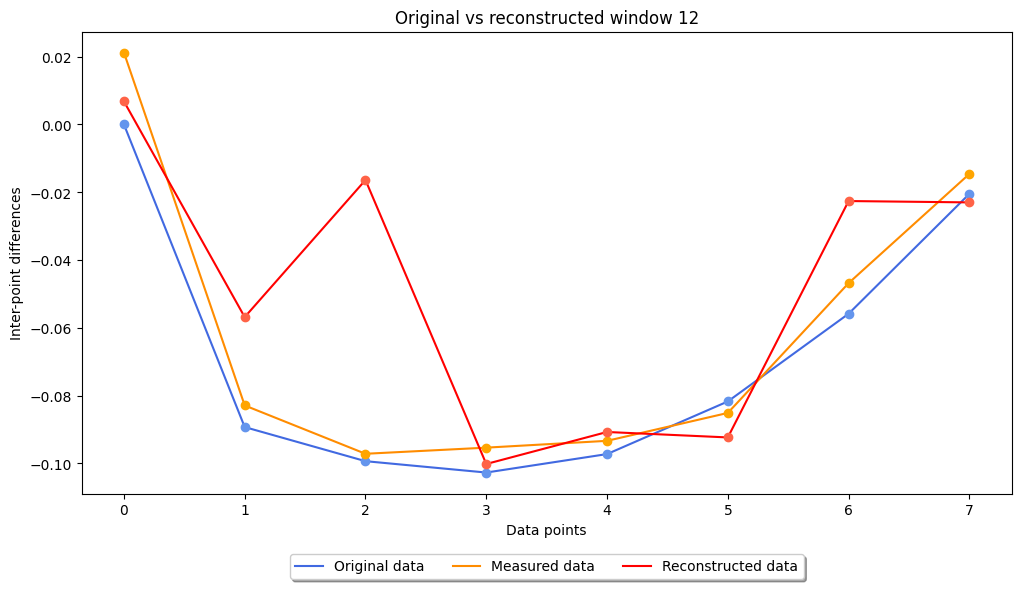

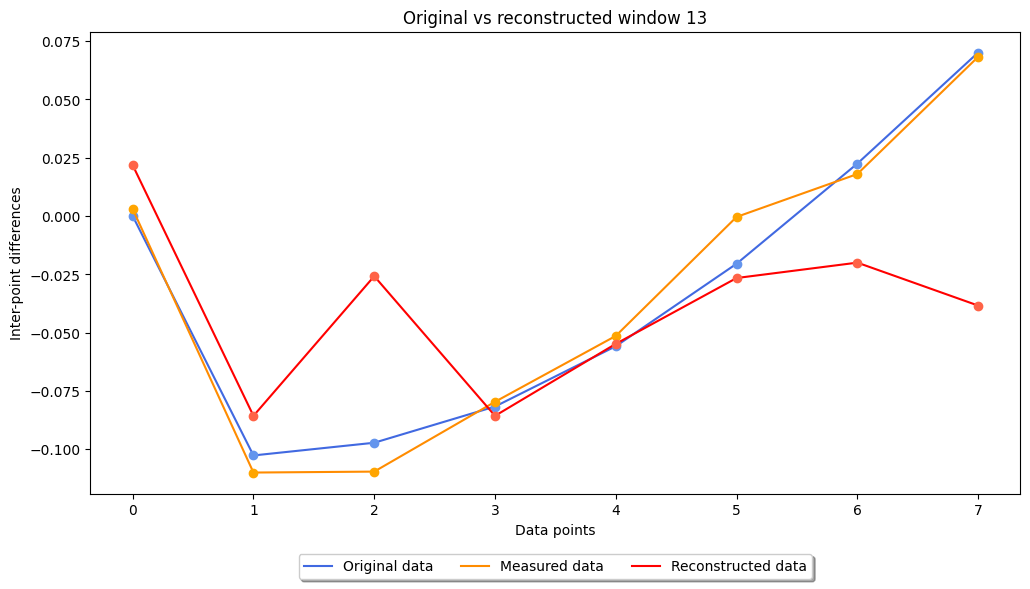

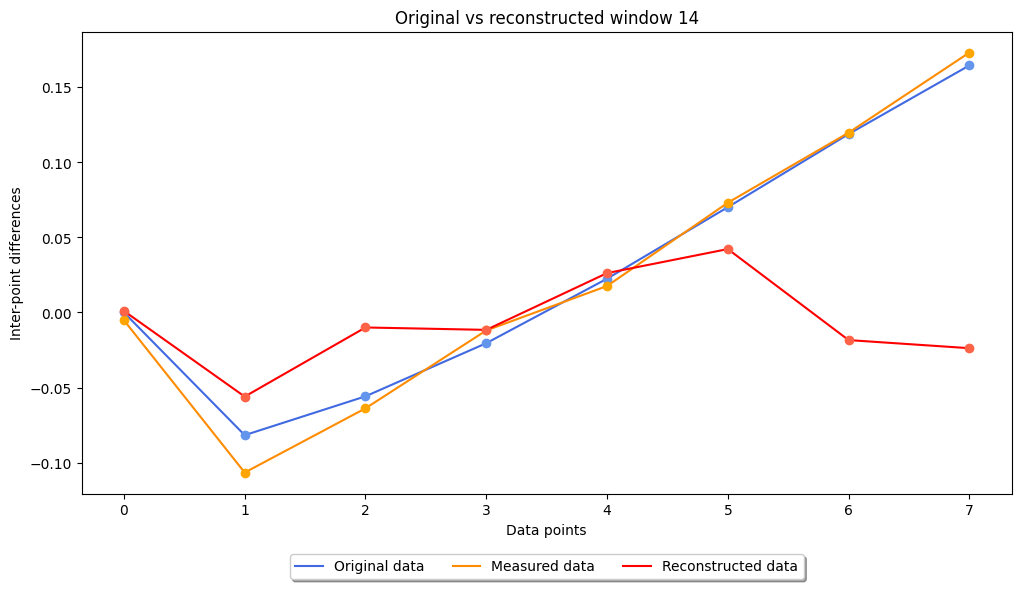

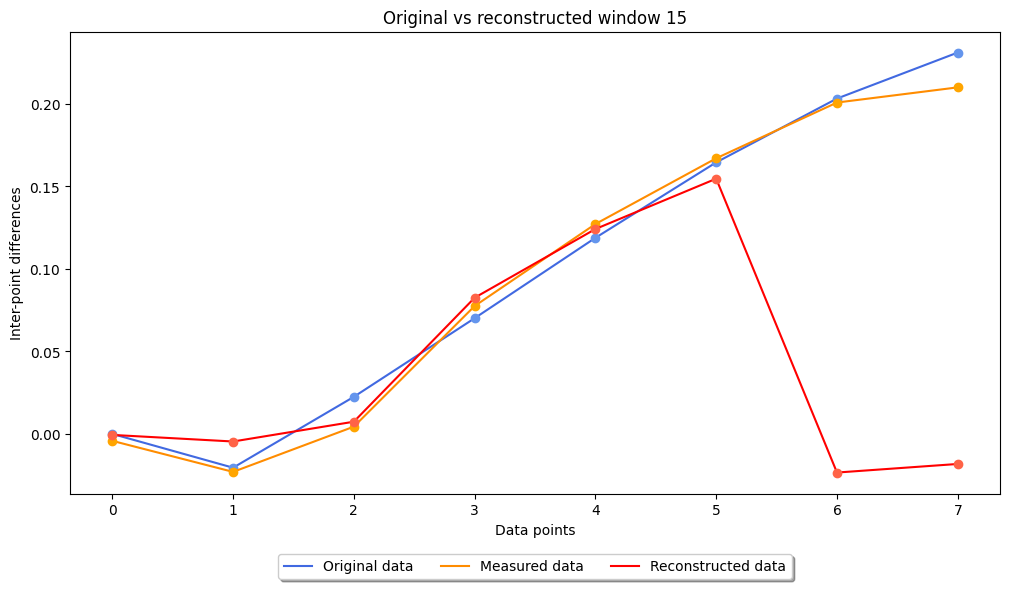

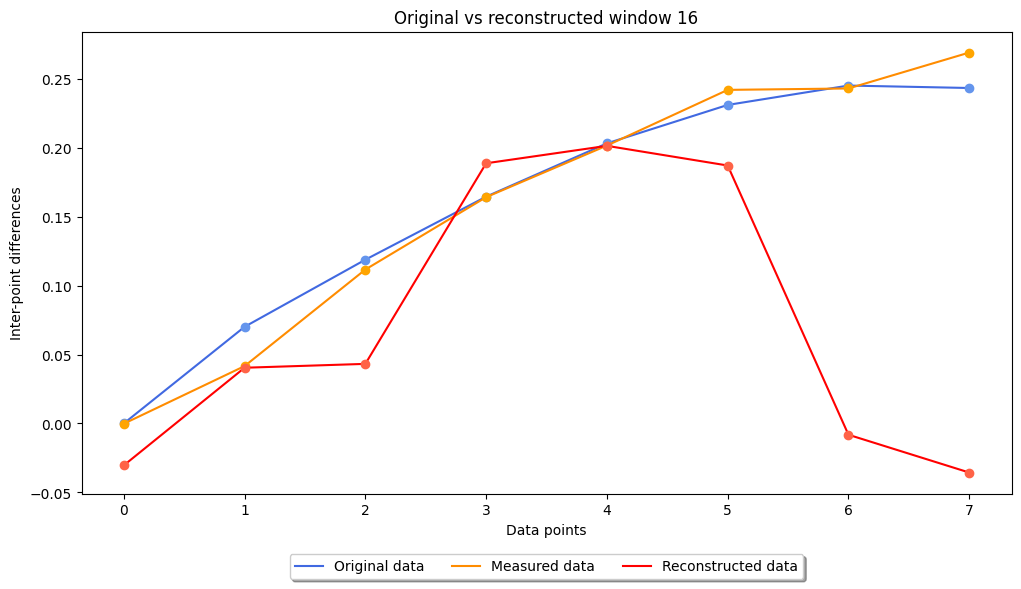

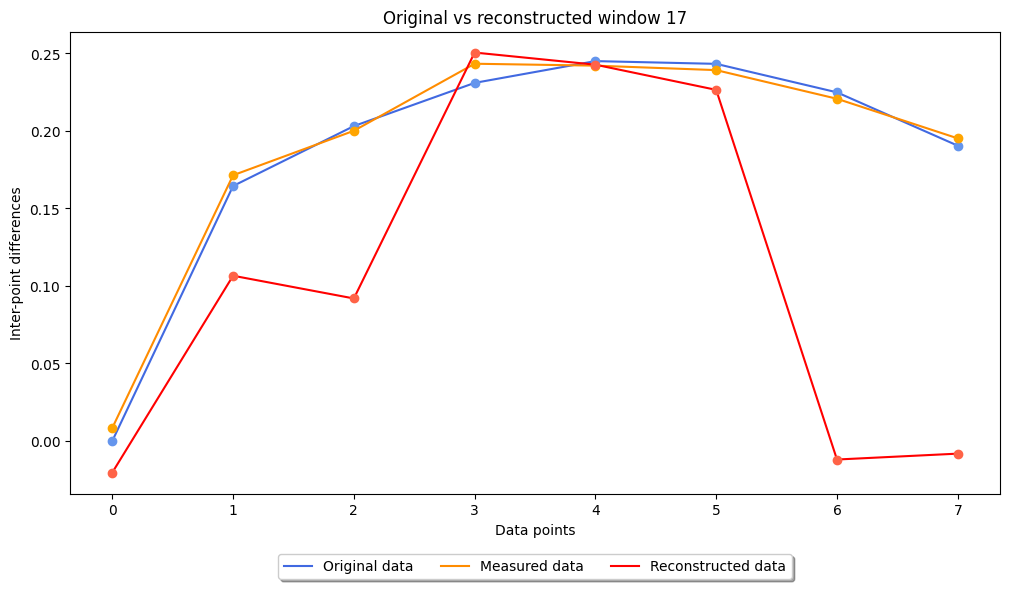

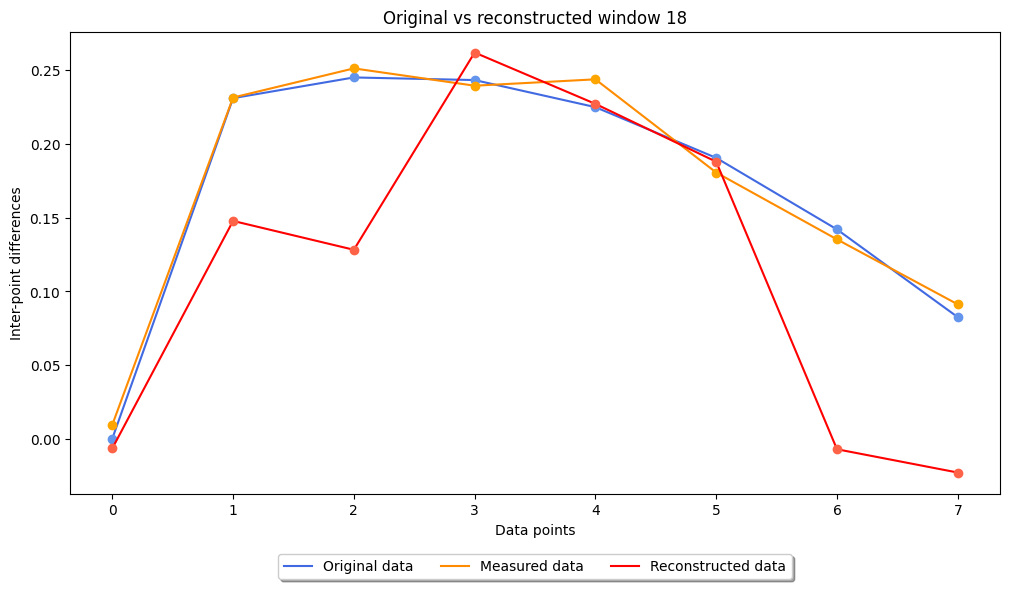

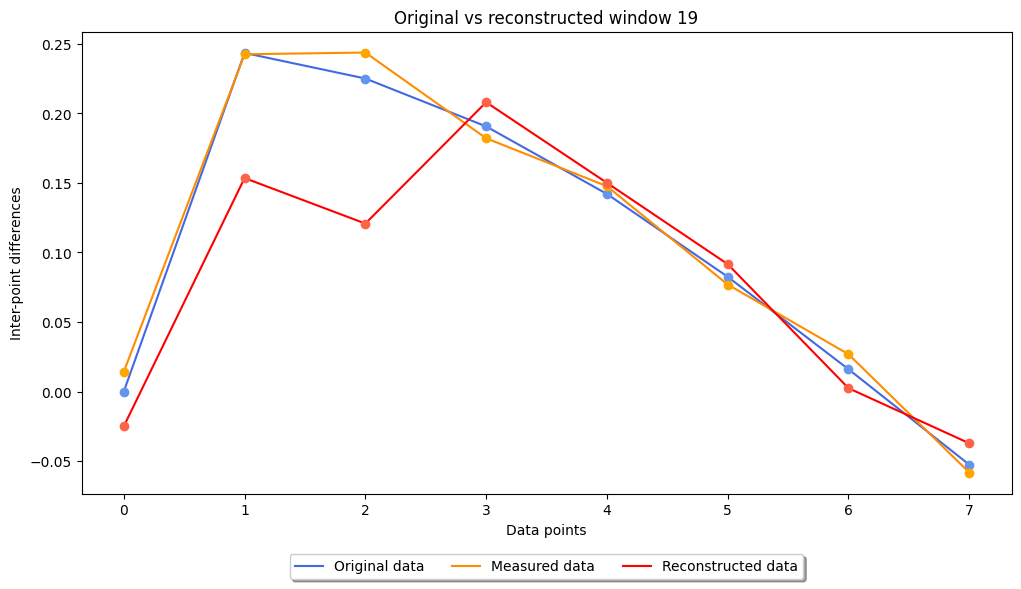

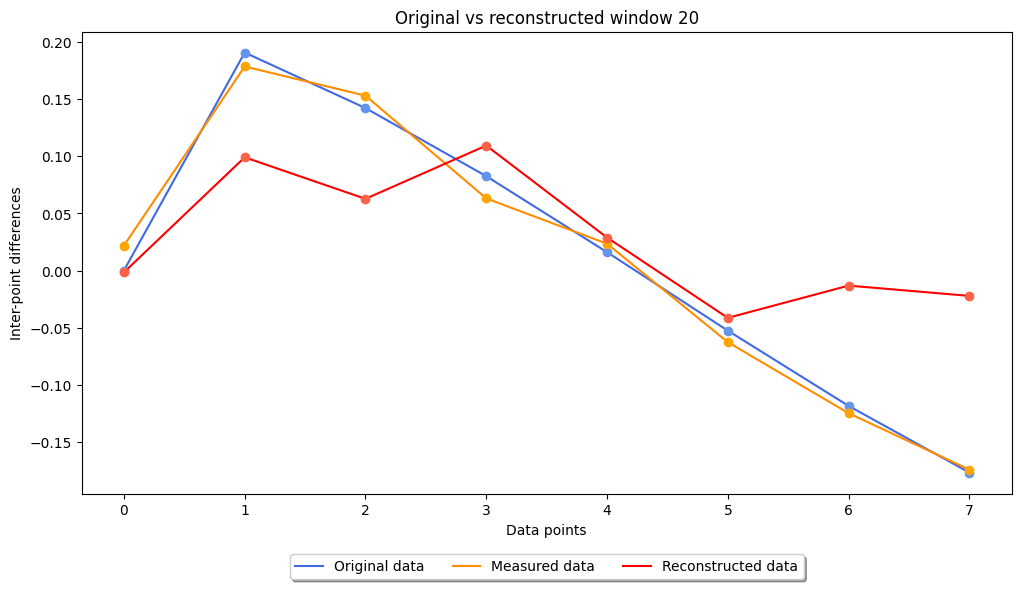

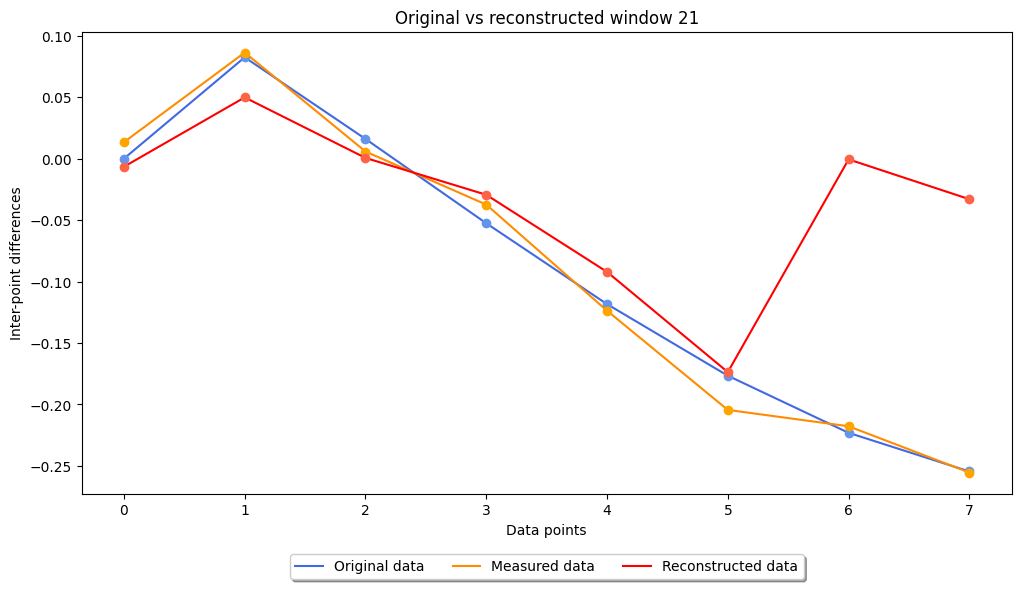

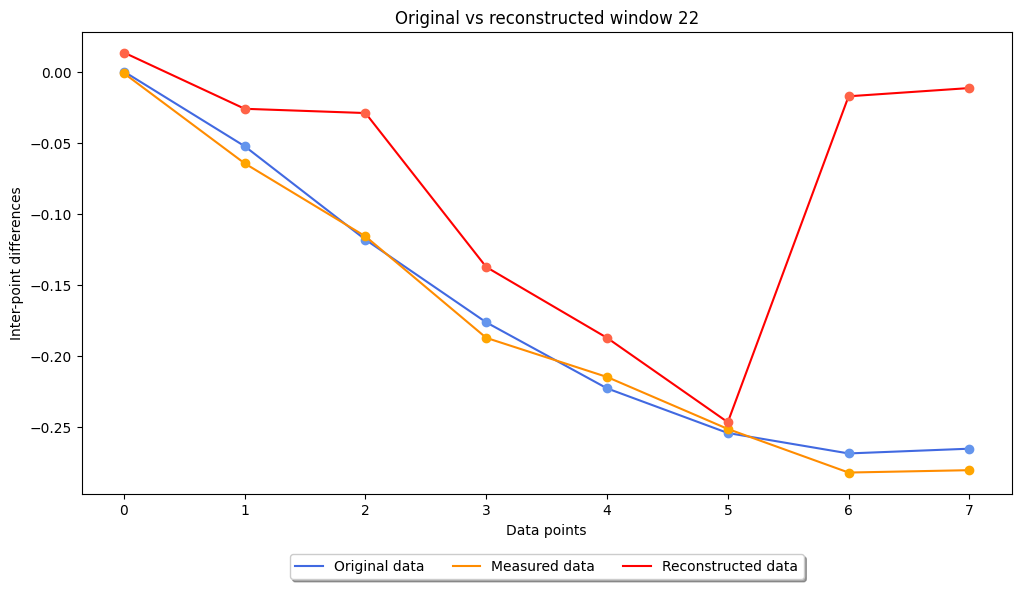

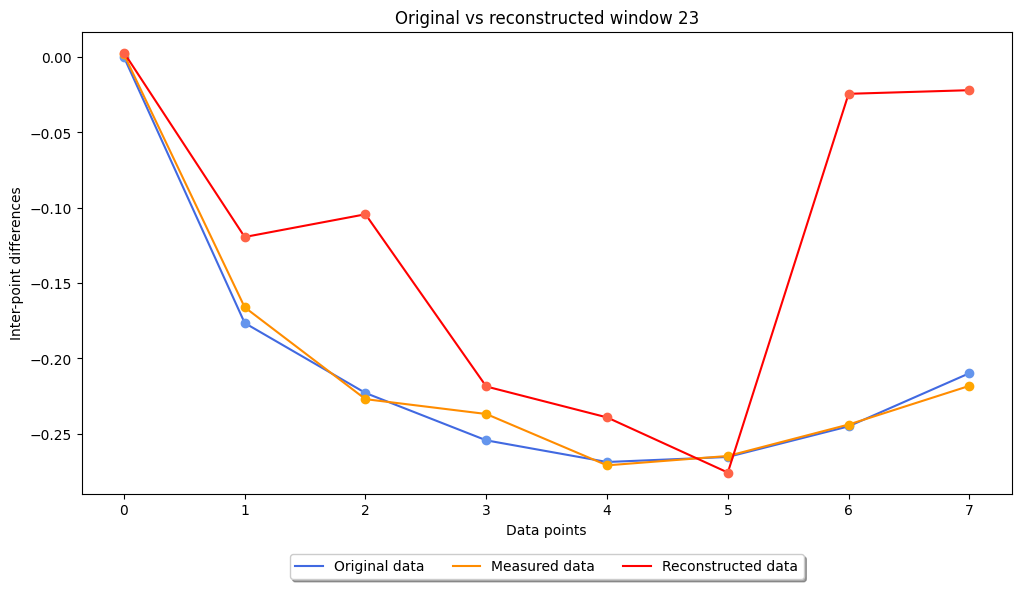

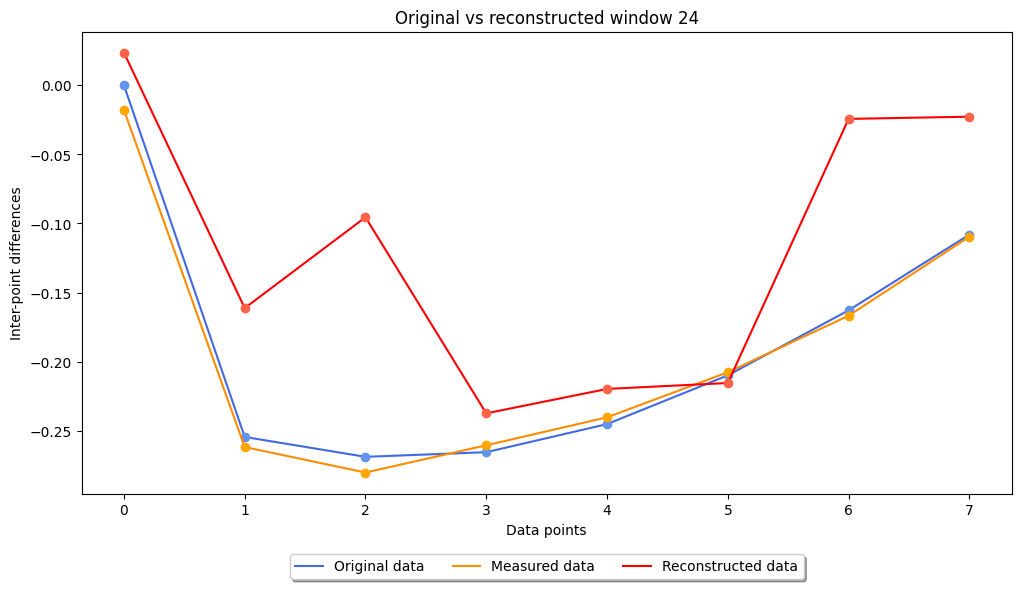

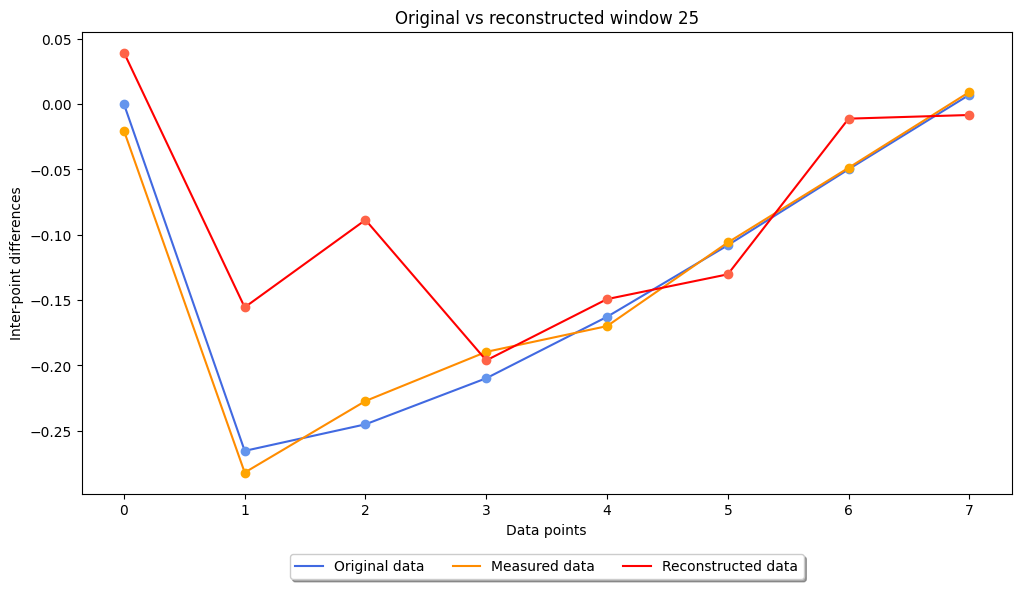

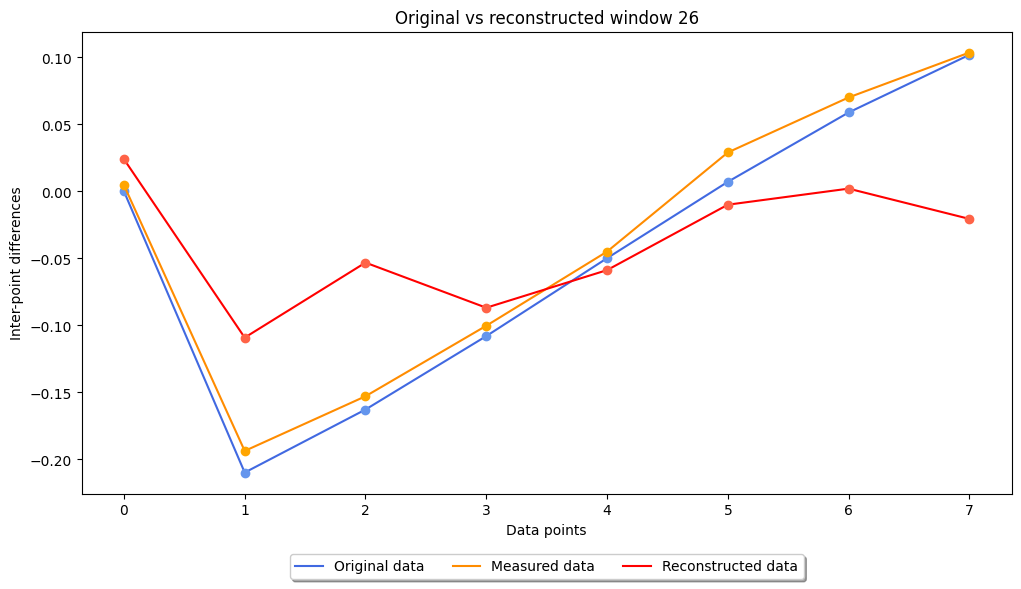

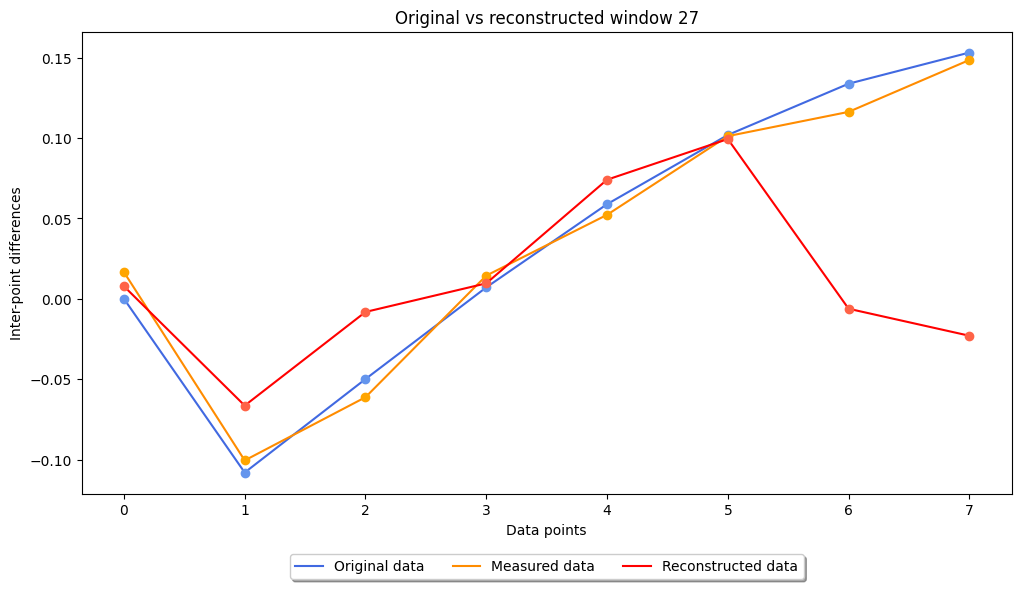

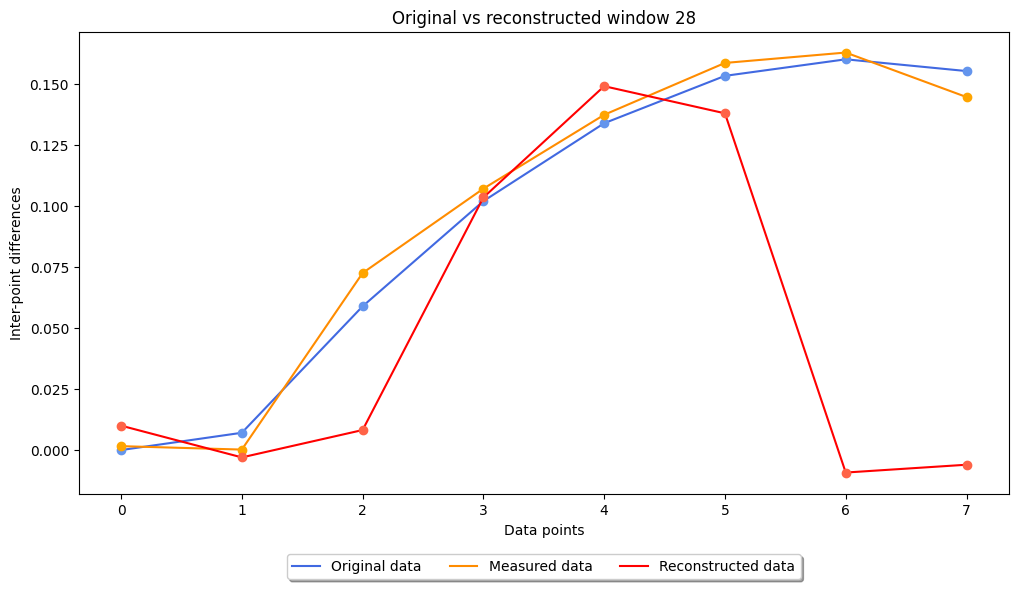

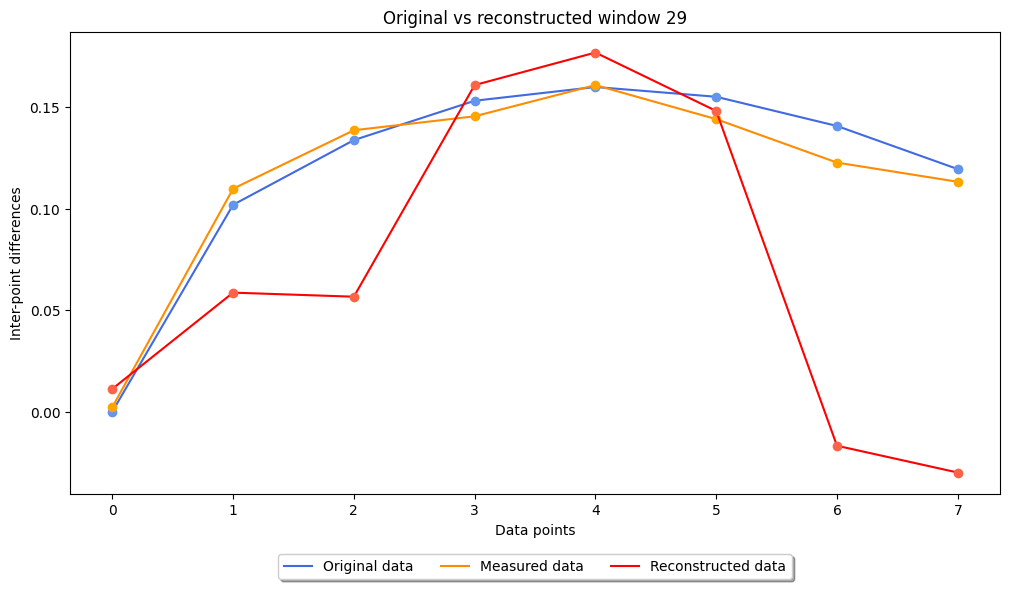

In [34]:
### Plot all the selected windows and their recovered data

for sel_wind in in_org_set.keys():

    # Retrieve window data
    print('\n')
    wind = in_org_set[sel_wind]
    org_meas = in_meas_set[sel_wind]
    out_meas = out_reconstr_set[sel_wind]    
    
    # Plot prepared data
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.title(f'Original vs reconstructed window {sel_wind}')
    plt.xlabel("Data points")
    plt.ylabel("Inter-point differences")
    # plt.xlim(lb, ub)
    
    # Plot target function
    plt.plot([x for x in range(len(wind))], wind, color='royalblue', label='Original data')
    plt.plot([x for x in range(len(wind))], wind, marker='o', color='cornflowerblue', linestyle='None')
    plt.plot([x for x in range(len(wind))], org_meas, color='darkorange', label='Measured data')
    plt.plot([x for x in range(len(wind))], org_meas, marker='o', color='orange', linestyle='None')
    plt.plot([x for x in range(len(wind))], out_meas, color='red', label='Reconstructed data')
    plt.plot([x for x in range(len(wind))], out_meas, marker='o', color='tomato', linestyle='None')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
              ncol=3, fancybox=True, shadow=True)
    plt.show()
    
print('\n')

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

## Logs

**Qiskit QAE with Unary Encoding**
- V1 Using QAE for anomaly detection (by denoising)
    - V1.1 Tested binary encoding, which misses proximity
    - V2.0 Created an "unary" encoding scheme
    - V2.1 Unary encoding tested with various options, not close
      - Issues noted:
          - Issue 01 (Completed) *Not sure how to interpret the output - cannot be visual*
          - Issue 02 (Completed) *Visual match between input and output not close*
          - **Issue 03** *Noise needs to be injected in training*
          - Issue 04 (Completed) *Training is getting slow, need to use GPU*
          - **Issue 05** *It is worth testing if an increase of the latent layer could improve the result*
      - Action planned:
          - *Add Aer GPU*, *Add noise in training*, *Add convolution*, *Create classical solution to compare*
    - V2.2 Adding GPU plus encoding test
      - Encoding test:
          - Tested amplitude encoding. To improve the QAE we may need to focus on other aspects of the model,
            e.g. incorporation of noise and improvement to the ansatz to ensure neighbourhoods are strongly
            entangled.
      - Several problems installing GPU support, attempt to address **Issue 04**
          - Issue 06 (Completed) *Several problems associated with GPU support*<br/>
          - **Fix 06** *Need to install ML 0.7.1+ and Aer 0.13.2+*<br/>
            ML 0.7.1 standard installation (no need to install from source anymore)<br/>
            Aer 0.13.2 requires CUDA + cuQuantum + cuTensor (Deb)<br/>
            - Note that Aer Sampler has a bug and will not work with RawFeatureVector.
          - **Fix 04** *With GPU the training speed increased ~2 times
    - V2.3 Attempt to move to PuTorch, abandoned for the time being
    - V2.4 Changing to angle encoding - relative with Ry over 2pi
      - Issues noted:
          - Issue 07 (Completed) *Negative numbers not coded properly*</br>
      - Action planned:
          - *Change encoding as relative from H over pi* - with [-1:0] pi/2 negatives towards |0> and [0:+1] pi/2 positives towards |1>
    - V2.5 Completed QAE with angle encoding, lots of fixes
      - Fixes completed:
          - **Fix 07** *Adopted encoding around H state, up negative, down positive*
          - **Fix 02** *Resulting QAE outputs better match the inputs*
          - **Fix 01** *With the new encoding, the output is easy to interpret*
      - Issues noted:
          - **Issue 08** *QAE reconstruction has large variance end of windows*, averaging overlapping windows may help
          - **Issue 09** *Need to reconstruct the entire series*, possibly with averaging of overlapping windows
      - Action planned:
          - *Experiment with data sets, window size, step size*


In [35]:
!pip list | grep -e qiskit -e torch -e tensorflow -e PennyLane

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0


In [36]:
import qiskit.tools.jupyter

# Note that Qiskit Terra and ML were compiled in from sources
%qiskit_version_table

# As this code was derived from Qiskit tutorial retain the following
%qiskit_copyright